## Regression Problem: Wind Production Prediction
In this exercise, we will solve a regression problem with a neural network.

**Objective:** The goal is to predict the electricity production of windmills in France.

**Dataset:**  A csv file with 8 784 samples from the year 2016 is provided (on the course webpage). Each example contains three input features describing the weather at that time. We will use 6 000 examples as training set, 1 000 as validation set and the rest as test set.   
   * **Feature names**: FR_windspeed_10, FR_temperature, FR_radiation_direct_horizontal
   * **Target**: FR_wind_onshore_generation_actual

**NB:** new required libraries: `pandas`, `seaborn`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns

%matplotlib inline

In [2]:
# Load data:
df = pd.read_csv("FR_wind_predict_2016.csv", parse_dates=[0], index_col=0)

In [3]:
df.head(3)

FR_wind_onshore_generation_actual  \
utc_timestamp                                                  
2016-01-01 00:00:00+00:00                             2082.0   
2016-01-01 01:00:00+00:00                             1690.0   
2016-01-01 02:00:00+00:00                             1414.0   

                           FR_windspeed_10m  FR_temperature  \
utc_timestamp                                                 
2016-01-01 00:00:00+00:00              2.86           5.571   
2016-01-01 01:00:00+00:00              2.68           5.415   
2016-01-01 02:00:00+00:00              2.51           5.288   

                           FR_radiation_direct_horizontal  
utc_timestamp                                              
2016-01-01 00:00:00+00:00                             0.0  
2016-01-01 01:00:00+00:00                             0.0  
2016-01-01 02:00:00+00:00                             0.0

In [4]:
df.info() # get more information

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8783 entries, 2016-01-01 00:00:00+00:00 to 2016-12-31 22:00:00+00:00
Data columns (total 4 columns):
FR_wind_onshore_generation_actual    8783 non-null float64
FR_windspeed_10m                     8783 non-null float64
FR_temperature                       8783 non-null float64
FR_radiation_direct_horizontal       8783 non-null float64
dtypes: float64(4)
memory usage: 343.1 KB


### Data Analysis
Before training, we need first to analyze the dataset, to know its properties better.

/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


(0, 10000)

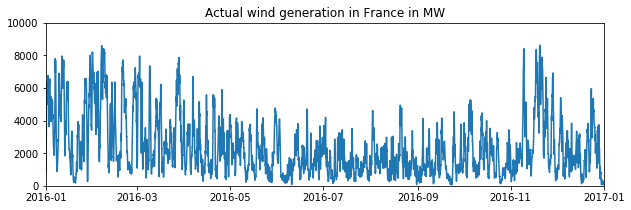

In [5]:

plt.figure(figsize=(10, 3))
plt.plot(df.index, df['FR_wind_onshore_generation_actual'])
plt.title('Actual wind generation in France in MW')
plt.xlim(pd.Timestamp('2016-01-01'), pd.Timestamp('2017-01-01'))
plt.ylim(0, 10000)

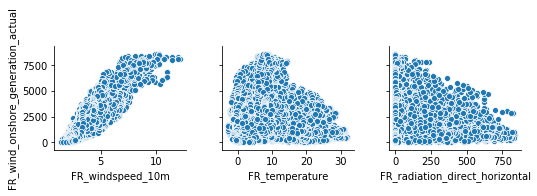

In [6]:
sns.pairplot(df, x_vars=['FR_windspeed_10m', 'FR_temperature', 'FR_radiation_direct_horizontal'], y_vars=['FR_wind_onshore_generation_actual'])

> As we can visualize, there exists some correlation between 'FR_windspeed_10m' and our label. This feature will probably have great importance in our model. 

Let's also visualize the matrix of correlations between the variables :

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2cf3a7f0>,
      dtype=object)

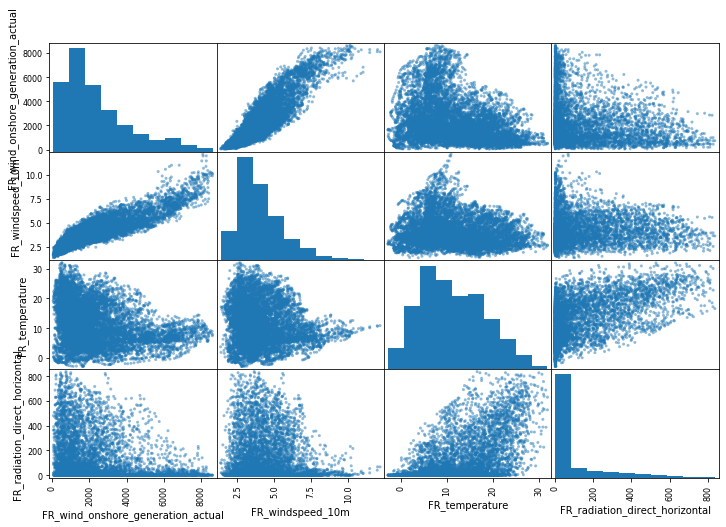

In [7]:
from pandas.plotting import scatter_matrix
attributes = df.columns
scatter_matrix(df[attributes], figsize=(12,8))

> Well, there isn't much additional on these plots...

### Wind prediction

Here is a skeleton of a neural network with a single layer (thus: a linear classifier). This is the model you'll start with and improve during this exercise.

Look at the code and run it to see its structure, then follow the questions below to iteratively improve the model.

In [8]:
X_wind = df[['FR_windspeed_10m', 'FR_temperature', 'FR_radiation_direct_horizontal']] # get the three features from the dataframe
y_wind = df["FR_wind_onshore_generation_actual"] # get the target values

In [9]:
X_train = X_wind.iloc[:6000]
y_train = y_wind.iloc[:6000]

# Normalize the data :
mu_var = np.mean(X_train, axis=0)
sigma_var = np.std(X_train, axis=0)
X_train = (X_train - mu_var)/sigma_var
#------------------------------
mu_lbl = np.mean(y_train, axis=0)
sigma_lbl = np.std(y_train, axis=0)
y_train = (y_train - mu_lbl)/sigma_lbl

X_val = X_wind.iloc[6000:7000]
y_val = y_wind.iloc[6000:7000]
X_val = (X_val - mu_var)/sigma_var
y_val = (y_val - mu_lbl)/sigma_lbl

X_test = X_wind.iloc[7000:]
y_test = y_wind.iloc[7000:]
X_test = (X_test - mu_var)/sigma_var
y_test = (y_test - mu_lbl)/sigma_lbl

In [10]:
# Construct a model with one layer
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.l1 = nn.Linear(3, 1)
        
    def forward(self, inputs):
        outputs = self.l1(inputs)
        return outputs

In [11]:
# Define hyper-parameters:
simple_model = Model()
print(simple_model)

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10

# Training criterion. This one is a mean squared error (MSE) loss between the output
# of the network and the target label
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(simple_model.parameters(), lr=0.01)

Model(
  (l1): Linear(in_features=3, out_features=1, bias=True)
)


In [12]:
train_set = TensorDataset(torch.from_numpy(np.array(X_train)).float(), 
                          torch.from_numpy(np.array(y_train)).float()) # create the dataset.

In [30]:
def evaluate(model, batch_size, display=True):
    # Calculate mean squared error on validation set
    test_criterion = nn.MSELoss()
    model.eval()
    with torch.no_grad():
        y_pre_val = model(torch.from_numpy(np.array(X_val)).float())
        if y_pre_val.shape[1]==1:
            y_pre_val = y_pre_val.view(-1)
        else:
            y_pre_val = y_pre_val[:,0]
        error = test_criterion(y_pre_val, torch.tensor(np.array(y_val)).float()).item()
        #else:
        #    error = criterion(y_pre_val, torch.tensor(np.array(y_val)).float()).item()
        #    error *= batch_size / len(y_val)
    if display:
        print('The loss on validation set is:', error)
    else:
        return error

def train(num_epochs, batch_size, criterion, optimizer, model, dataset, freq_print=1, display=True):
    train_error = []
    validation_error = []
    dataloader = DataLoader(dataset, batch_size, shuffle=True)
    for epoch in range(num_epochs):
        ### Train the model
        model.train()
        epoch_average_loss = 0.0
        for (X, y) in (dataloader):
            
            y_pre = model(X)
            if y_pre.shape[1]==1:
                y_pre = y_pre.view(-1)
            loss = criterion(y_pre, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(train_set)
        train_error.append(epoch_average_loss)
        
        ### Evaluate the performance of our model
        val_error = evaluate(model, batch_size, display=False)
        validation_error.append(val_error)
        
        if (epoch%freq_print == 0) and display:
                print('Epoch [{}/{}],\tTrain_Loss_error: {:.4f},\tVal_Loss_error: {:.4f}'
                      .format(epoch+1, num_epochs,  epoch_average_loss, val_error))
                
    return train_error, validation_error

In [14]:
train_error, validation_error = train(num_epochs, batch_size, criterion, optimizer, 
                                      simple_model, train_set)

Epoch [1/10],	Train_Loss_error: 0.2444,	Val_Loss_error: 0.1216
Epoch [2/10],	Train_Loss_error: 0.1488,	Val_Loss_error: 0.1217
Epoch [3/10],	Train_Loss_error: 0.1489,	Val_Loss_error: 0.1219
Epoch [4/10],	Train_Loss_error: 0.1491,	Val_Loss_error: 0.1237
Epoch [5/10],	Train_Loss_error: 0.1489,	Val_Loss_error: 0.1219
Epoch [6/10],	Train_Loss_error: 0.1489,	Val_Loss_error: 0.1210
Epoch [7/10],	Train_Loss_error: 0.1488,	Val_Loss_error: 0.1214
Epoch [8/10],	Train_Loss_error: 0.1490,	Val_Loss_error: 0.1224
Epoch [9/10],	Train_Loss_error: 0.1487,	Val_Loss_error: 0.1232
Epoch [10/10],	Train_Loss_error: 0.1488,	Val_Loss_error: 0.1214


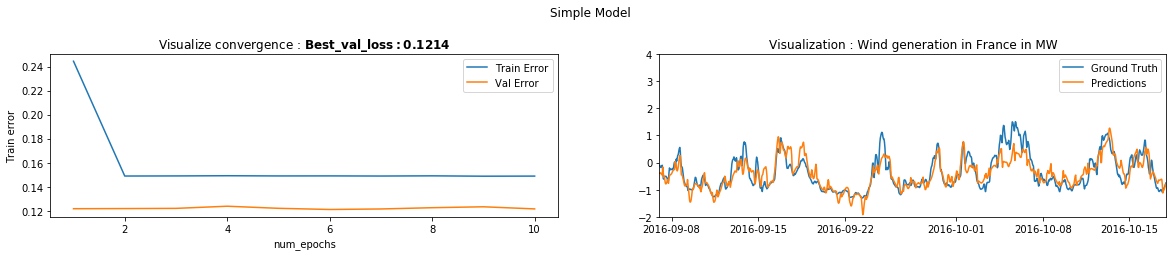

In [15]:
def plot_convergence(train_error, validation_error, model, title=''):
    # plot the training error wrt. the number of epochs: 
    plt.figure(figsize=(20,3))
    plt.suptitle(title,y=1.10)
    plt.subplot(121)
    plt.plot(range(1, len(train_error)+1), train_error, label='Train Error')
    plt.plot(range(1, len(train_error)+1), validation_error, label='Val Error')
    plt.xlabel("num_epochs")
    plt.ylabel("Train error")
    plt.legend()
    plt.title("Visualize convergence : $\mathbf{Best\_val\_loss : %.4f}$" % (validation_error[-1]))
    
    # Get the predictions and plot them
    model.eval()
    with torch.no_grad():
        y_pre = model(torch.from_numpy(np.array(X_val)).float())
        if y_pre.shape[1]==1:
            y_pre = y_pre.view(-1)
        else:
            y_pre = y_pre[:,1]
    
    plt.subplot(122)
    plt.plot(y_val.index, np.array(y_val), label='Ground Truth')
    plt.plot(y_val.index, y_pre.numpy(), label='Predictions')
    plt.title('Visualization : Wind generation in France in MW')
    plt.xlim(pd.Timestamp('2016-09-07'), pd.Timestamp('2016-10-18'))
    plt.ylim(-2, 4)
    plt.legend()
    
plot_convergence(train_error, validation_error, simple_model, title='Simple Model')

> It seems that the model is not converging after one epoch...

#### Evaluate the Model on the validation set

In [17]:
evaluate(simple_model, batch_size)

The loss on validation set is: 0.12144101411104202


### Exercise 1: Impact of the architecture of the model

The class `Model` is the definition of your model. You can now modify it to try out different architectures and
see the impact of the following factors:

* Try to add more layers (1, 2, 3, more ?)
* Try different activation functions ([sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.)
* Try to change the number of neurons in each layer (5, 10, 20, more ?)

In [48]:
class MultiLayerModel(nn.Module):
    def __init__(self, n_hidden_layers=0, n_neurons=2, hidden_activations=torch.relu, nb_output=1):
        # Note that since we are doing a regression task, we don't use any output activation function.
        super(MultiLayerModel, self).__init__()
        self.nb_output = nb_output
        self.n_layers = n_hidden_layers
        if type(n_neurons)==int:
            self.n_neurons = [3] + [n_neurons for _ in range(n_hidden_layers)]
        else:
            assert type(n_neurons)==list
            assert len(n_neurons)==n_hidden_layers
            self.n_neurons = [3] + n_neurons
        
        for i in range(self.n_layers):
            input_dim = self.n_neurons[i]
            output_dim = self.n_neurons[i+1]
            setattr(self,
                    "layer_{}".format(i+1),
                    nn.Linear(input_dim, output_dim))
            #if self.nb_output==2:
            #    setattr(self,
            #            "BatchNorm_{}".format(i+1),
            #            nn.BatchNorm1d(num_features=output_dim))

        if self.nb_output==2:
            self.mu_1 = nn.Linear(self.n_neurons[-1], 30)
            self.mu_2 = nn.Linear(30, 1)
            self.sigma_1 = nn.Linear(self.n_neurons[-1], 50)
            self.sigma_2 = nn.Linear(50, 20)
            self.sigma_3 = nn.Linear(20, 20)
            self.sigma_4 = nn.Linear(20, 1)
        
        else:
            self.out = nn.Linear(self.n_neurons[-1], self.nb_output)
        
        self.hidden_activations = hidden_activations
    
    def forward(self, inputs):
        x = inputs
        for i in range(self.n_layers):
            x = getattr(self, "layer_{}".format(i+1))(x)
            if i < self.n_layers - 1:
                x = self.hidden_activations(x)
        if self.nb_output==2:
            mu = self.hidden_activations(self.mu_1(x))
            mu = self.mu_2(mu)
            sigma = self.hidden_activations(self.sigma_1(x))
            sigma = self.hidden_activations(self.sigma_2(sigma))
            sigma = self.hidden_activations(self.sigma_3(sigma))
            sigma = self.sigma_4(sigma)
            return (mu, sigma)
        else:
            outputs = self.out(x)
            return outputs

Let's display a first result :

In [19]:
n_hidden_layers=3
n_neurons=4

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10

# Training criterion. This one is a mean squared error (MSE) loss between the output
# of the network and the target label
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
model = MultiLayerModel(n_hidden_layers, n_neurons)
print('The model used is :\n', model)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

train_error, validation_error = train(num_epochs, batch_size, criterion, optimizer, model, 
                                      train_set, display=False)

The model used is :
 MultiLayerModel(
  (layer_1): Linear(in_features=3, out_features=4, bias=True)
  (layer_2): Linear(in_features=4, out_features=4, bias=True)
  (layer_3): Linear(in_features=4, out_features=4, bias=True)
  (out): Linear(in_features=4, out_features=1, bias=True)
)


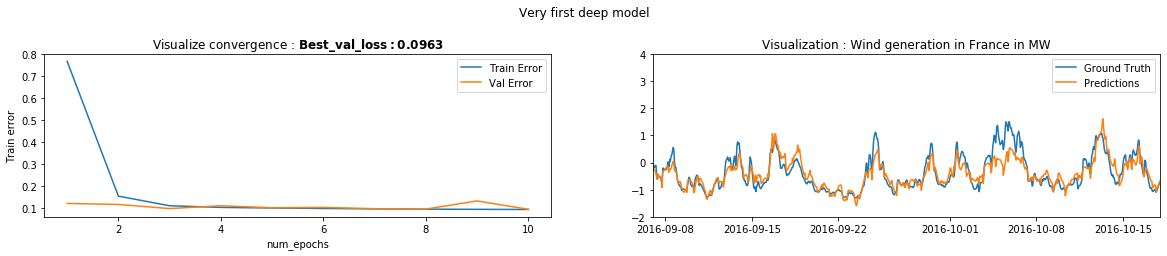

In [20]:
plot_convergence(train_error, validation_error, model, title='Very first deep model')

> Unfortunatly it is not way better...

Let's try to find a working set of parameters to make sure the problem has a convenient solution :

In [21]:
n_hidden_layers=5
n_neurons=[4,5,6,7,10]

# Choose the hyperparameters for training: 
num_epochs = 200
batch_size = 32

# Training criterion. This one is a mean squared error (MSE) loss between the output
# of the network and the target label
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
model = MultiLayerModel(n_hidden_layers, n_neurons)
print('The model used is :\n', model)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

train_error, validation_error = train(num_epochs, batch_size, criterion, optimizer, model, 
                                      train_set, display=False)

The model used is :
 MultiLayerModel(
  (layer_1): Linear(in_features=3, out_features=4, bias=True)
  (layer_2): Linear(in_features=4, out_features=5, bias=True)
  (layer_3): Linear(in_features=5, out_features=6, bias=True)
  (layer_4): Linear(in_features=6, out_features=7, bias=True)
  (layer_5): Linear(in_features=7, out_features=10, bias=True)
  (out): Linear(in_features=10, out_features=1, bias=True)
)


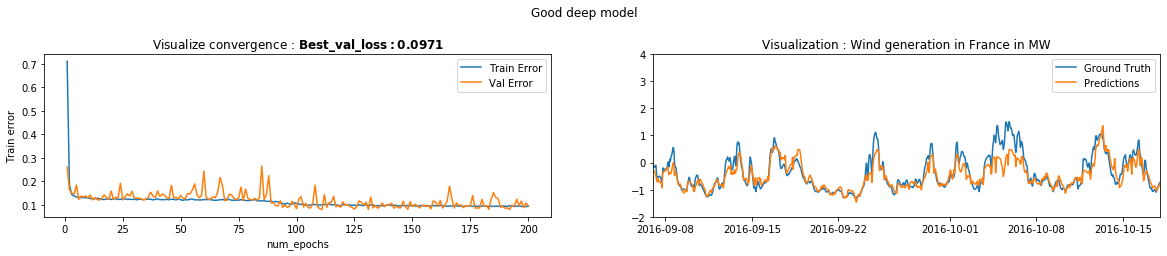

In [22]:
plot_convergence(train_error, validation_error, model, title='Good deep model')

> [...]

**Impact of the number of hidden layers :**

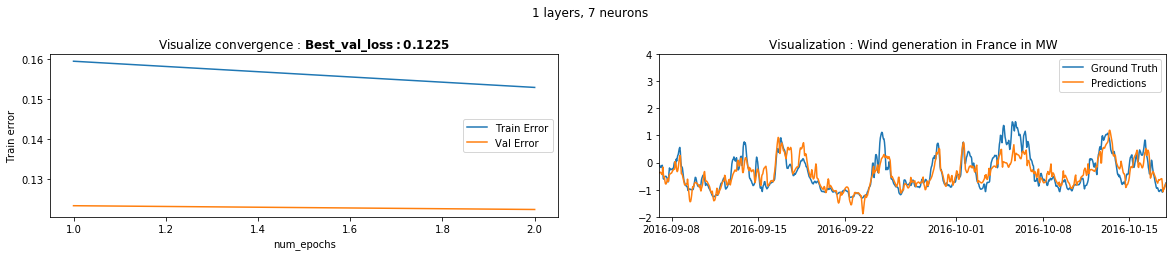

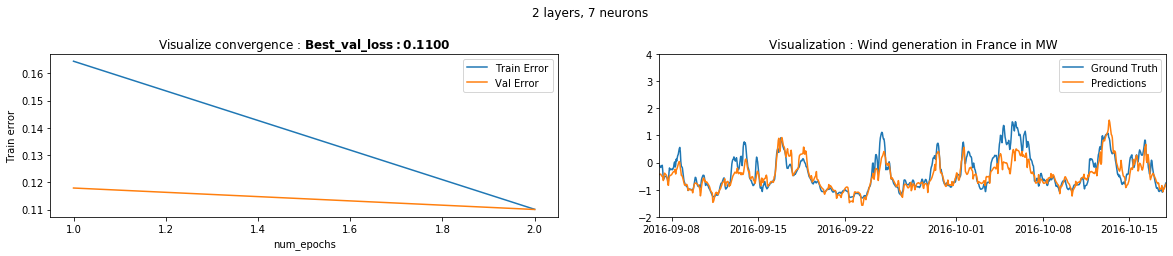

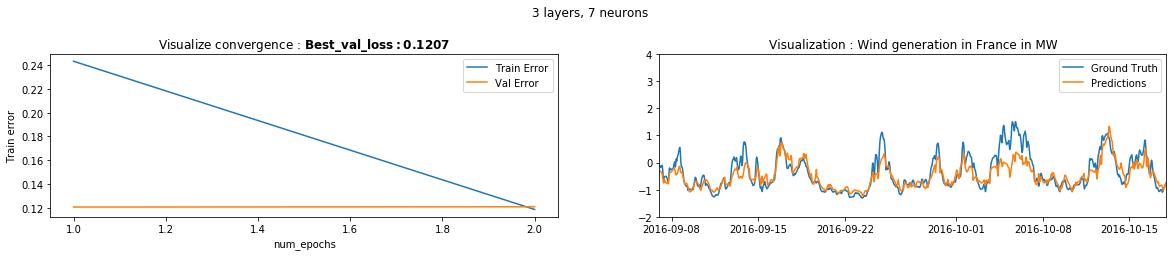

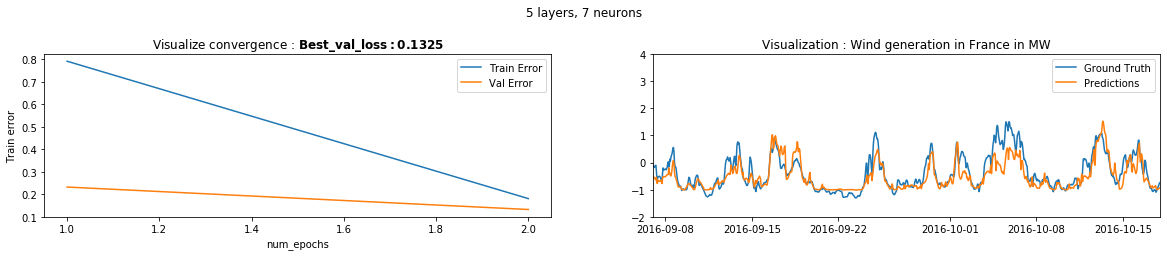

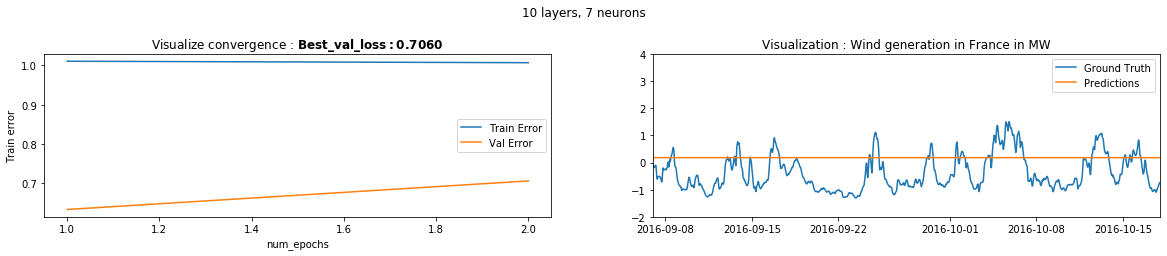

In [23]:
num_epochs = 2
batch_size = 32
test_hidden_layers = [1,2,3,5,10]
#nb_models = len(test_hidden_layers)
n_neurons = 7

#plt.figure(figsize=(16,3))
#plt.suptitle('$\mathit{Comparing\ the\ number\ of\ hidden\ layers,\ using\ relu\ activation}$', y=1.15)
for model_idx, h_l in enumerate(test_hidden_layers):
    ### Train the model
    model = MultiLayerModel(h_l, n_neurons, hidden_activations=torch.relu)
    #print('The model used is :\n', model)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    train_error, validation_error = train(num_epochs, batch_size, criterion, optimizer, model, 
                                          train_set, display=False)

    #plt.subplot(1, nb_models, model_idx+1)
    plot_convergence(train_error, validation_error, model, title='{} layers, {} neurons'.format(h_l, n_neurons))

---

**Impact of the activation function :**

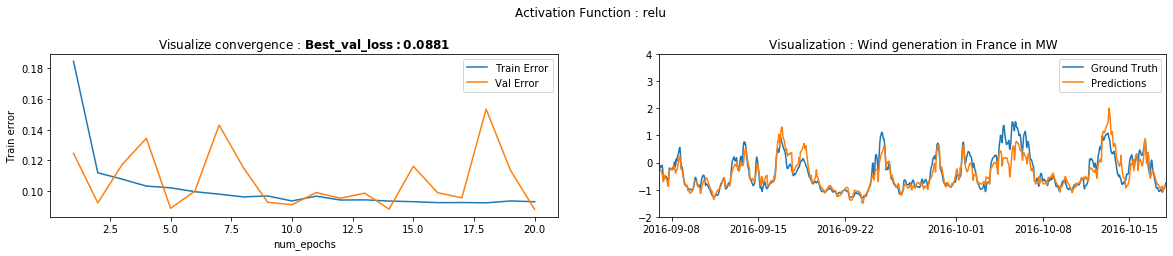

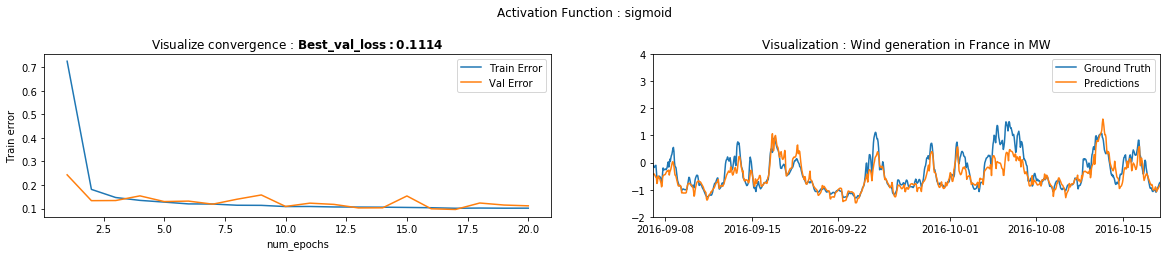

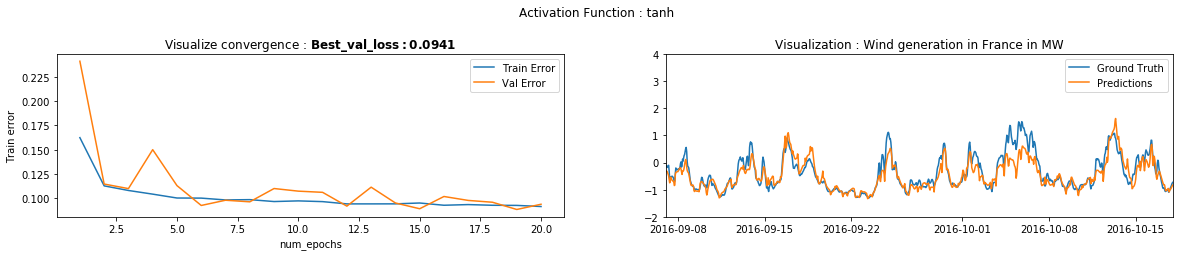

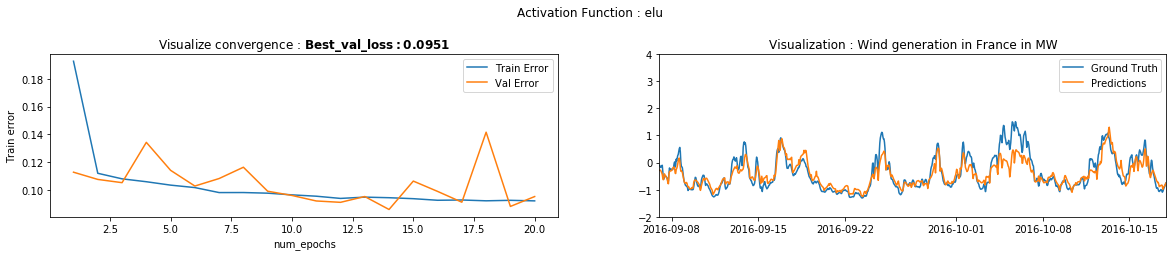

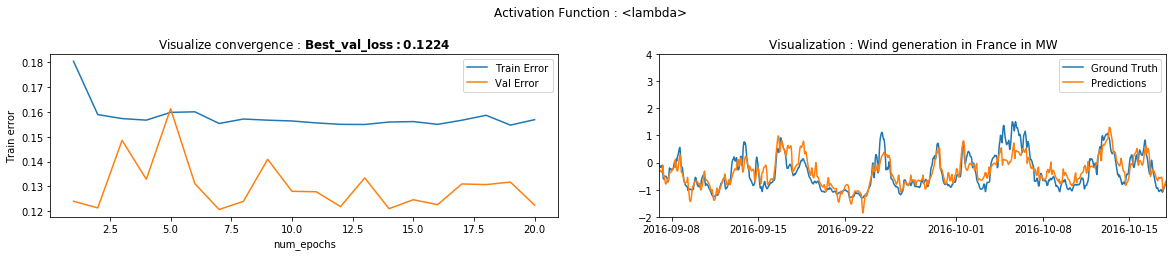

In [24]:
num_epochs = 20
batch_size = 32
test_activations = [torch.relu, torch.sigmoid, torch.tanh, torch.nn.functional.elu, lambda x: x]
#nb_models = len(test_hidden_layers)

#plt.figure(figsize=(16,3))
#plt.suptitle('$\mathit{Comparing\ the\ activation\ function,\ using\ 3 hidden\ layers\ and\ 10 neurons}$',
#             y=1.15)
for model_idx, activation_fct in enumerate(test_activations):
    ### Train the model
    model = MultiLayerModel(n_hidden_layers=3, n_neurons=10, hidden_activations=activation_fct)
    #print('The model used is :\n', model)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    train_error, validation_error = train(num_epochs, batch_size, criterion, optimizer, model,
                                          train_set, display=False)
    
    #plt.subplot(1, nb_models, model_idx+1)
    plot_convergence(train_error, validation_error, model,
                     title='Activation Function : {}'.format(activation_fct.__name__))

---

**Impact of the number of neurons :**

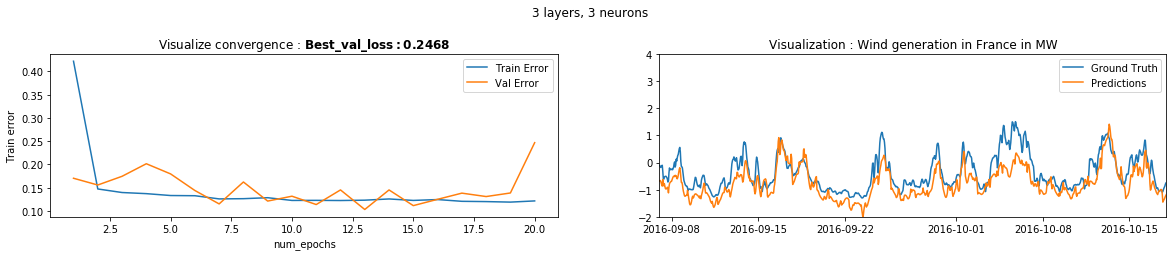

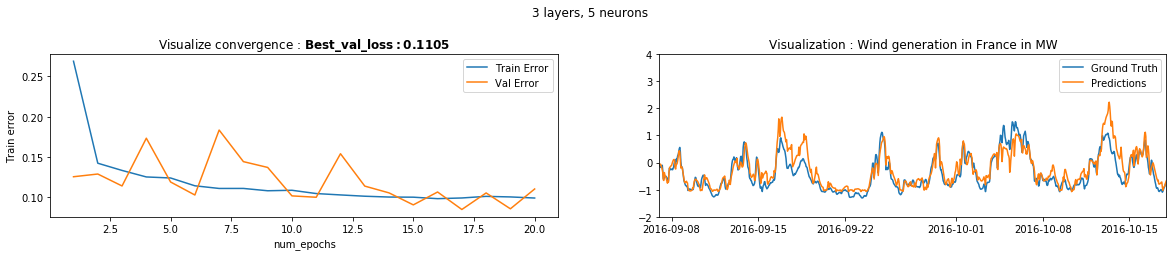

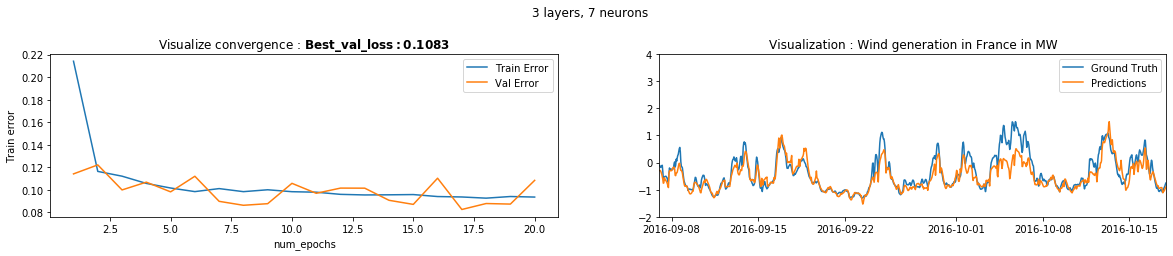

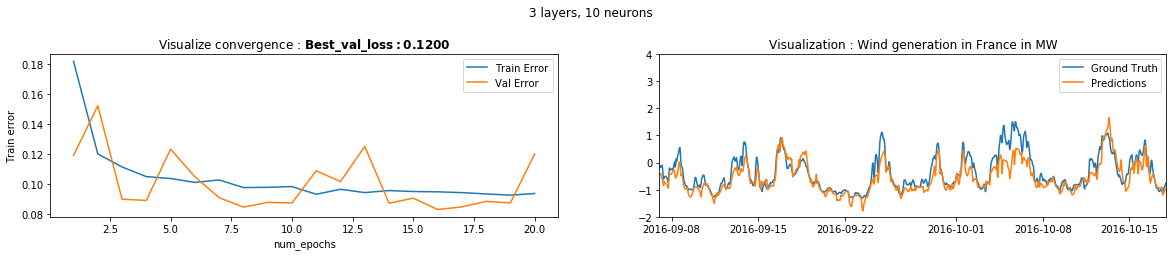

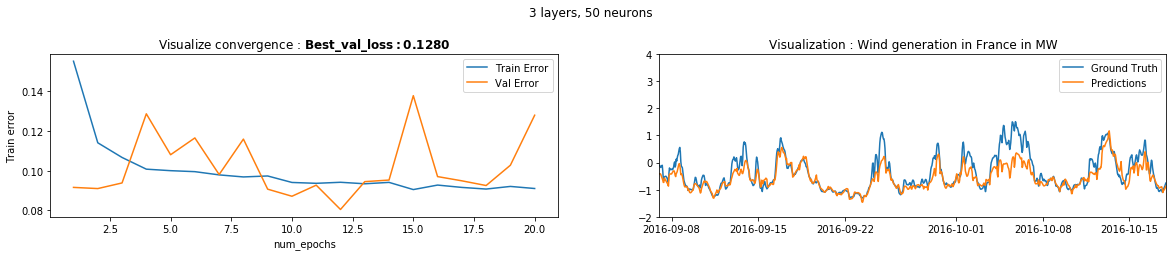

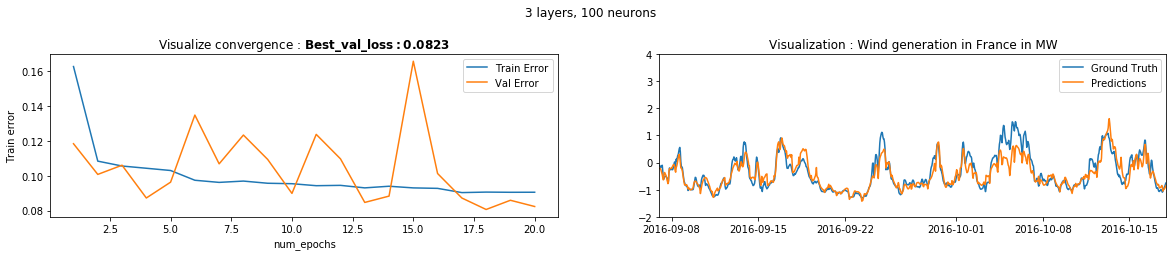

In [25]:
num_epochs = 20
batch_size = 32
test_neurons = [3,5,7,10,50,100]
#nb_models = len(test_neurons)

#plt.figure(figsize=(16,6))
#plt.subplots_adjust(hspace=0.8)
#plt.suptitle('$\mathit{Comparing\ the\ number\ of\ neurons,\ using\ 3 hidden\ layers\ and\ relu\ activation}$',
#             y=1.15)
for model_idx, neuron in enumerate(test_neurons):
    ### Train the model
    model = MultiLayerModel(n_hidden_layers=3, n_neurons=neuron, hidden_activations=torch.relu)
    #print('The model used is :\n', model)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    train_error, validation_error = train(num_epochs, batch_size, criterion, optimizer, model,
                                          train_set, display=False)

    #plt.subplot(2, nb_models//2, model_idx+1)
    plot_convergence(train_error, validation_error, model, title='3 layers, {} neurons'.format(neuron))

### Exercise 2: Impact of the optimizer

Retrain the model with different parameters of the optimizer; you can change then in the cell initializing the optimizer, after the definition of your model.

* Use different batch sizes, from 10 to 400 e.g.
* Try different values of the learning rate (between 0.001 and 10), and see how they impact the training process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

**Note:** These changes may interact with your previous choices of architectures, and you may need to change them as well!

---

**Impact of the batch size :**

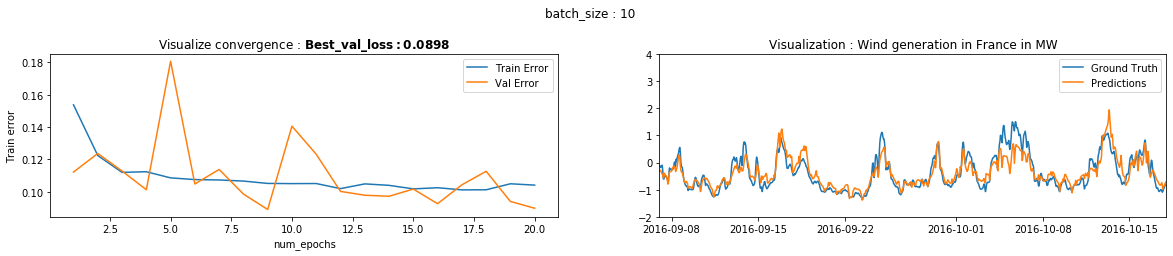

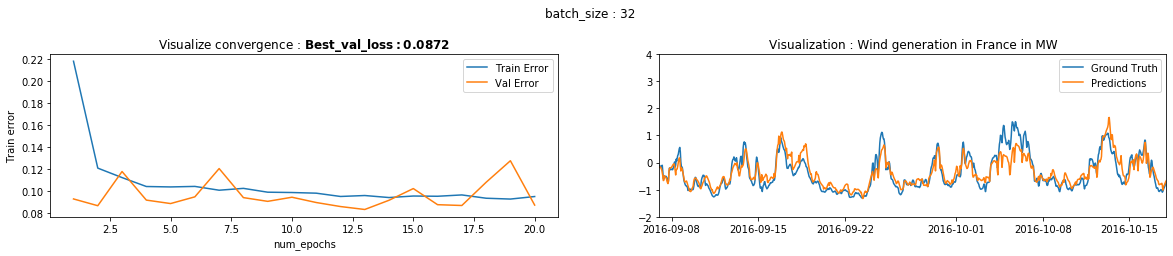

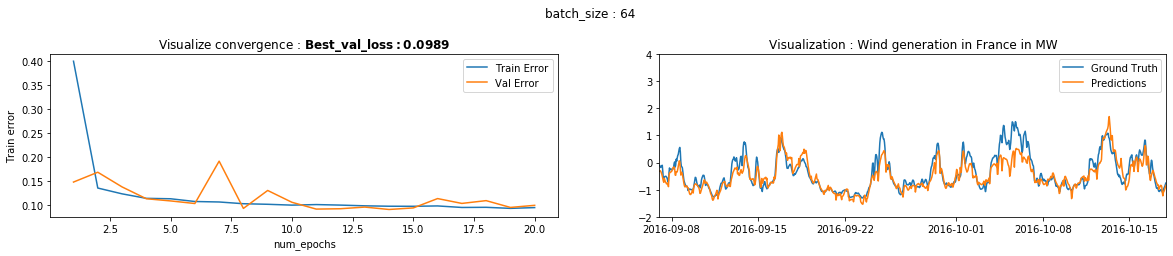

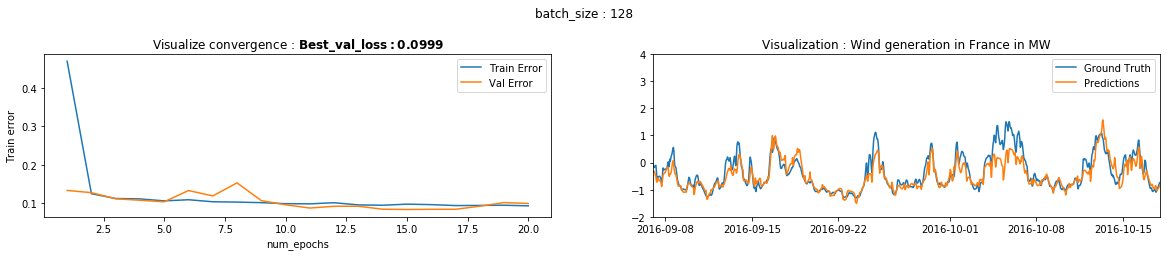

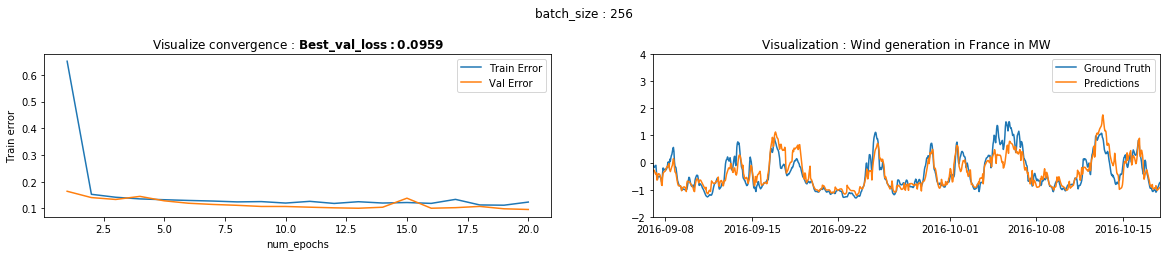

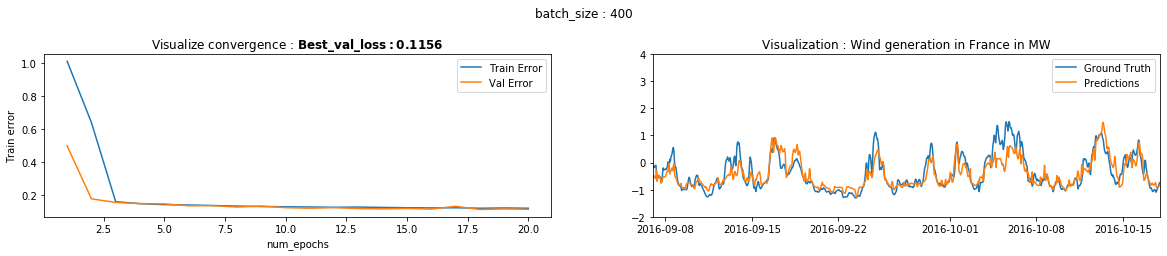

In [26]:
num_epochs = 20
test_batch_size = [10,32,64,128,256,400]
#nb_models = len(test_batch_size)

#plt.figure(figsize=(16,6))
#plt.subplots_adjust(hspace=0.8)
#plt.suptitle('$\mathit{Comparing\ the\ batch\ size,\ using\ 3\ hidden\ layers,\ 7\ neurons\ and\ relu\ activation}$',
#             y=1.05)
for model_idx, b_s in enumerate(test_batch_size):
    ### Train the model
    model = MultiLayerModel(n_hidden_layers=3, n_neurons=7, hidden_activations=torch.relu)
    #print('The model used is :\n', model)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    train_error, validation_error = train(num_epochs, b_s, criterion, optimizer, model, 
                                          train_set, display=False)

    #plt.subplot(2, nb_models//2, model_idx+1)
    plot_convergence(train_error, validation_error, model, title='batch_size : {}'.format(b_s))

---

**Impact of the learning rate for several models :**

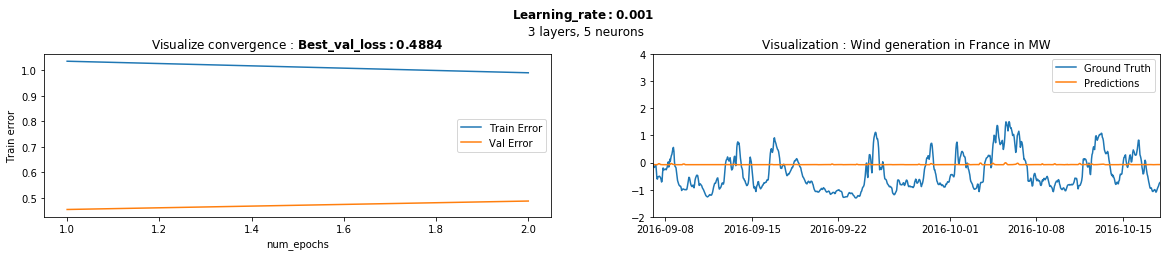

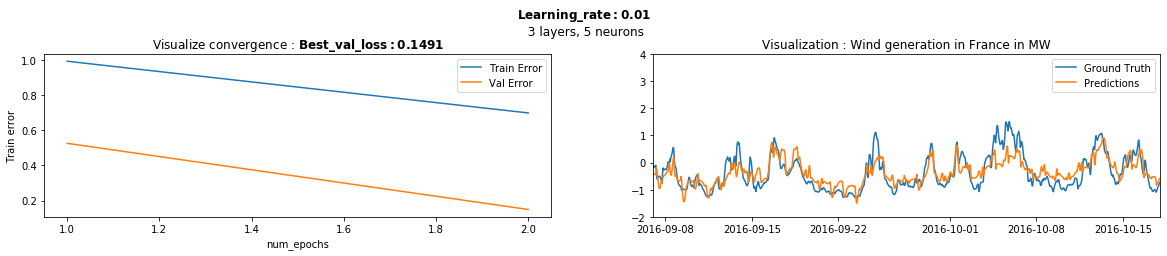

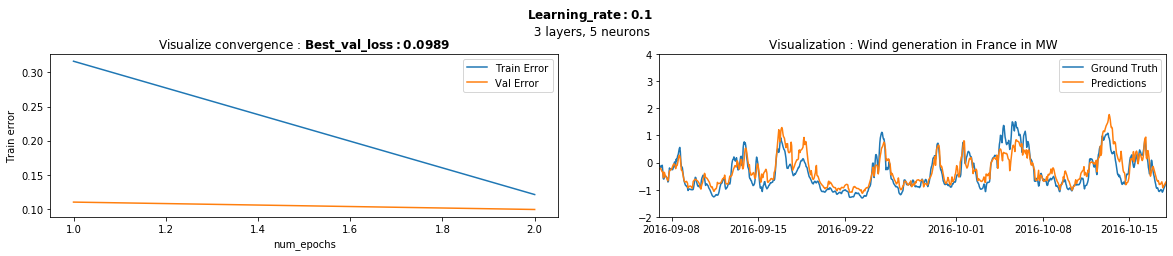

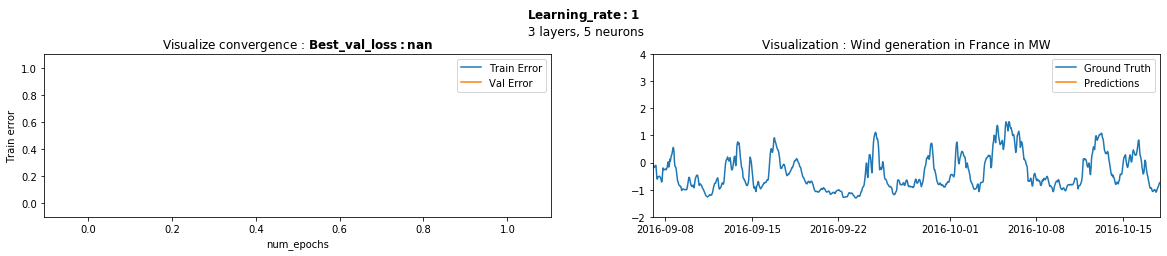

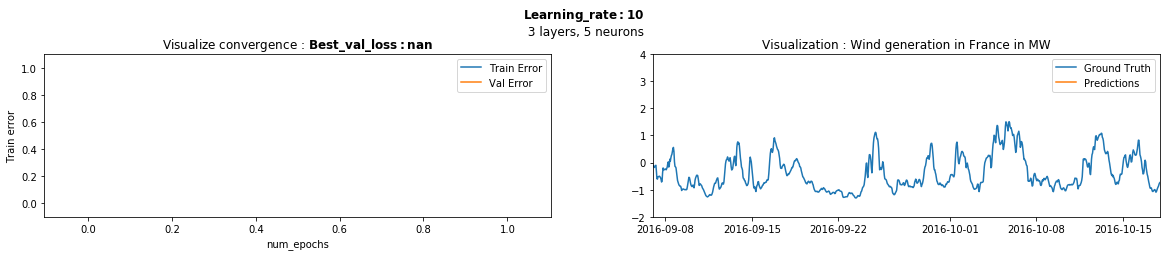

---------------------------------------------------------------------------------------------------------------------


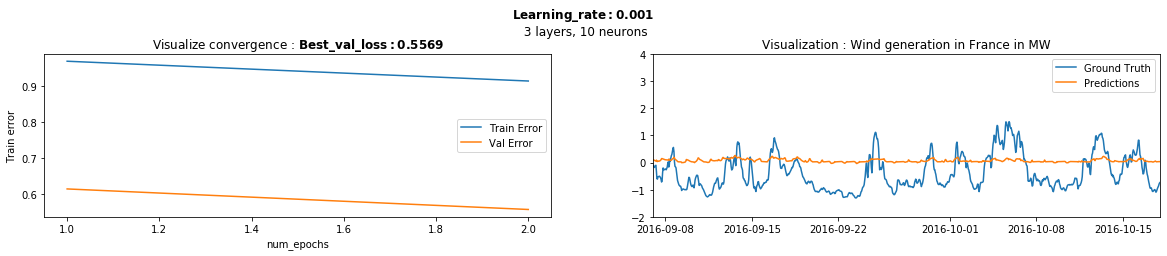

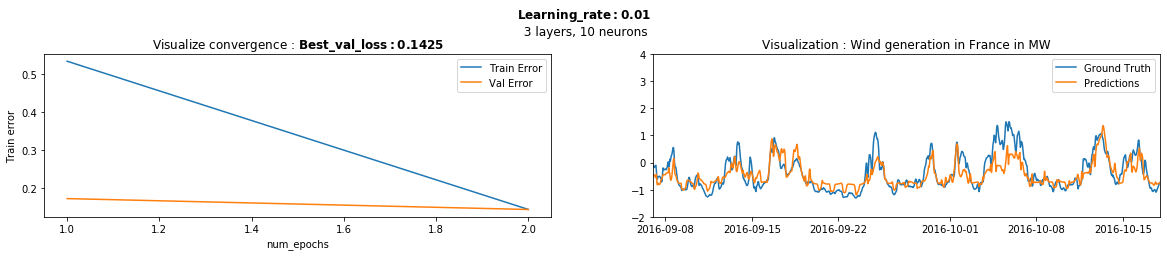

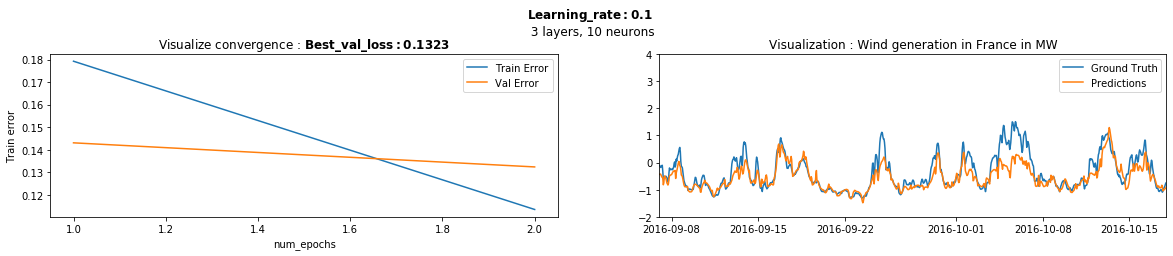

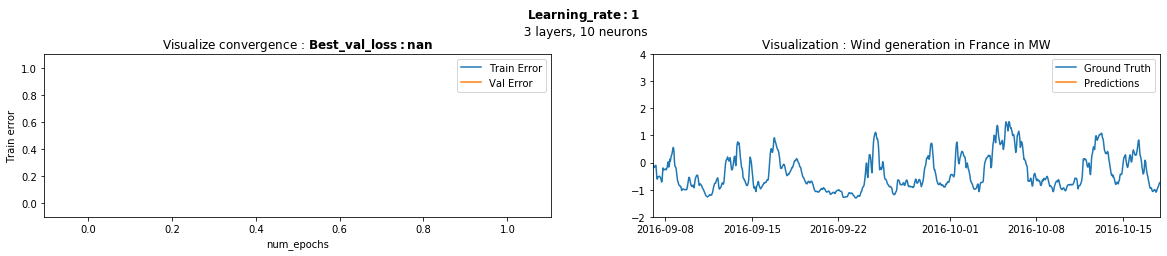

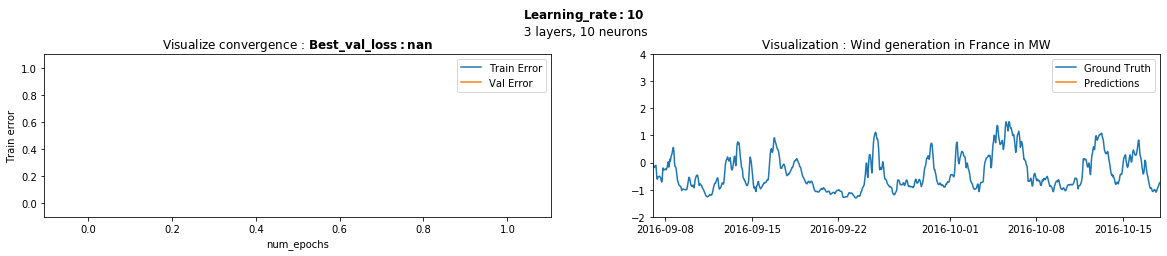

---------------------------------------------------------------------------------------------------------------------


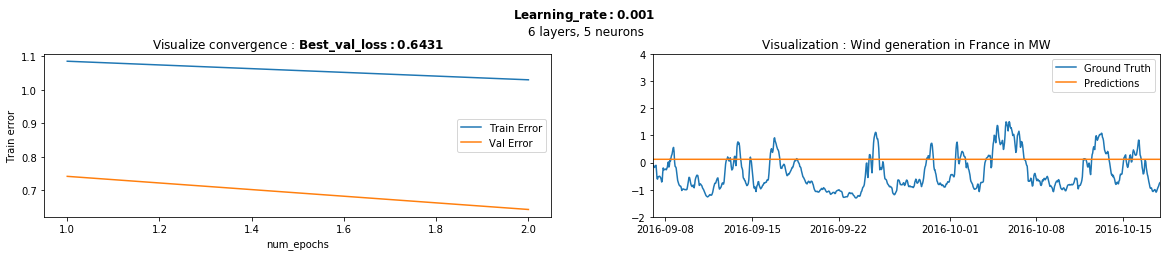

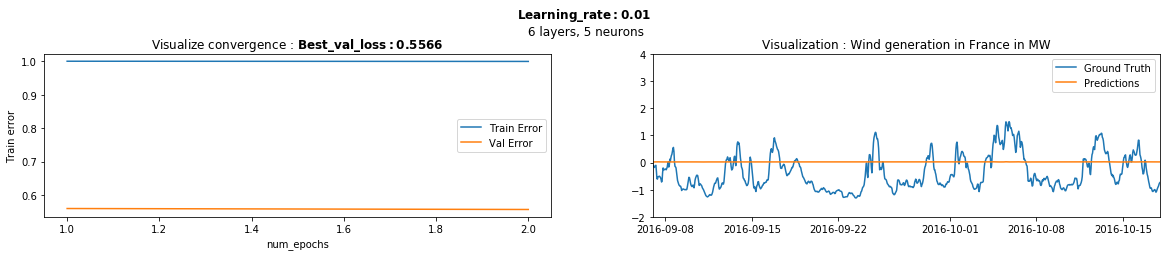

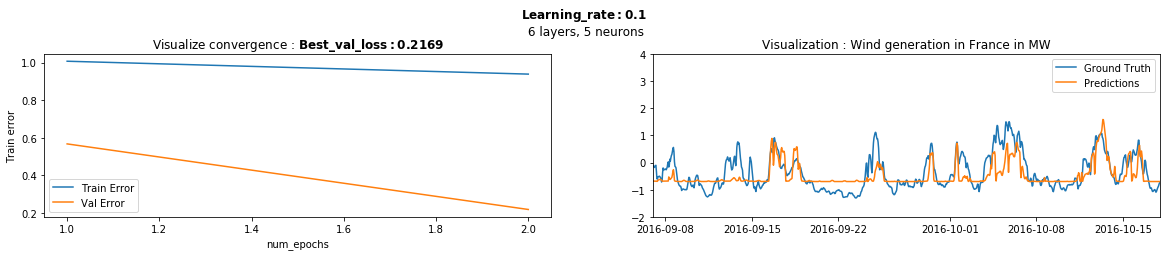

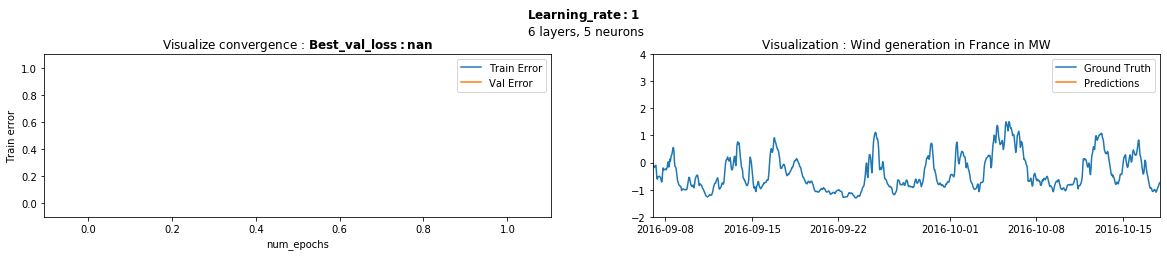

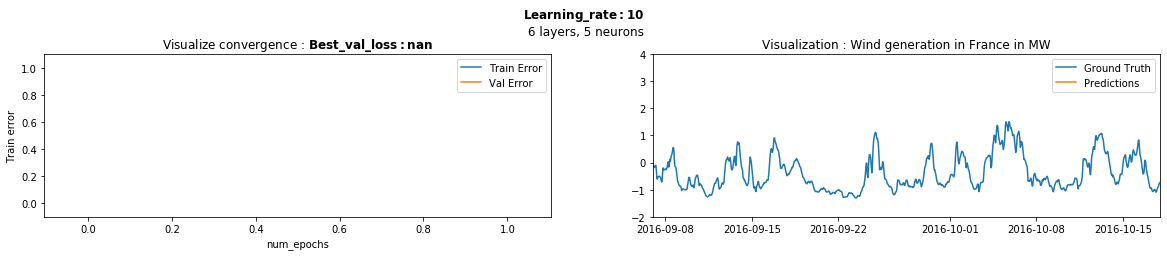

---------------------------------------------------------------------------------------------------------------------


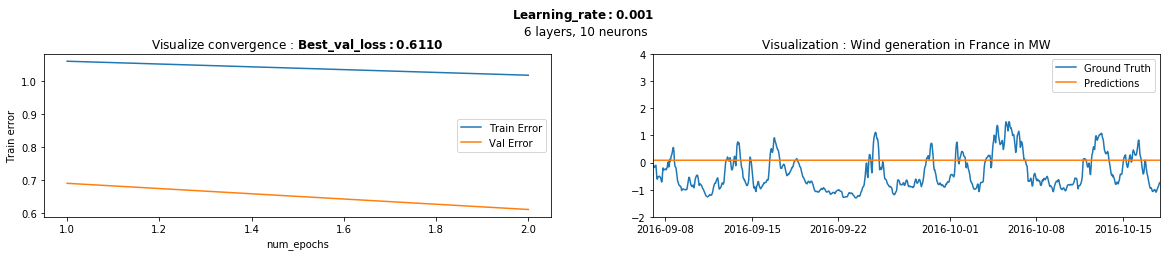

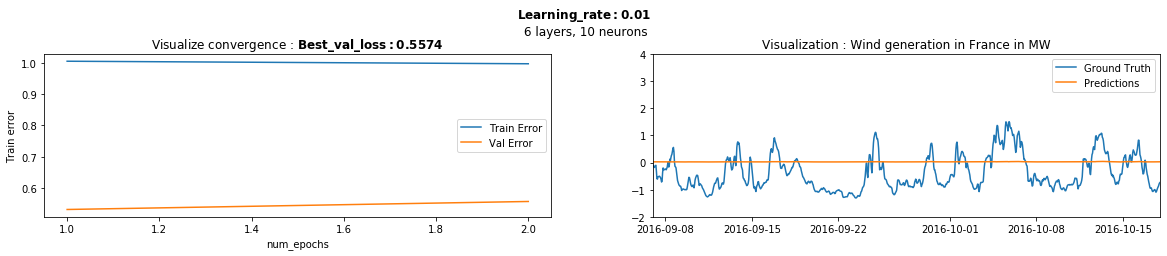

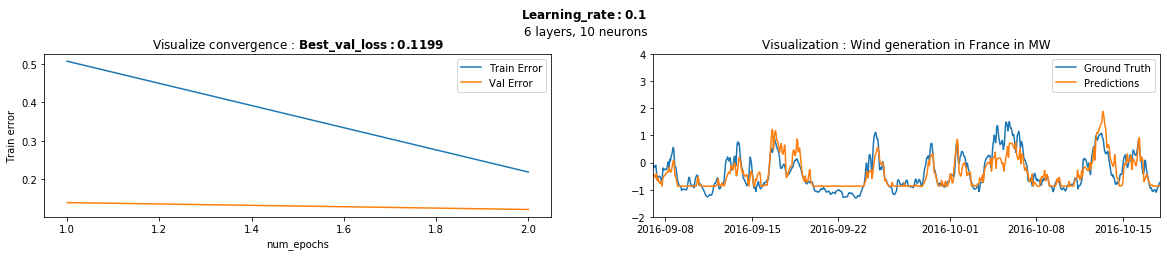

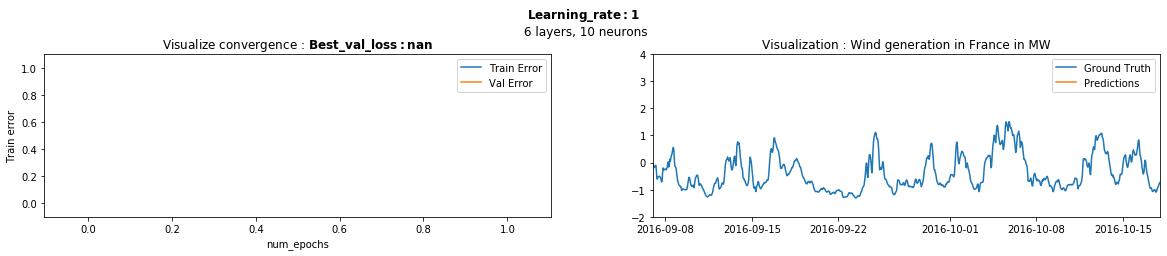

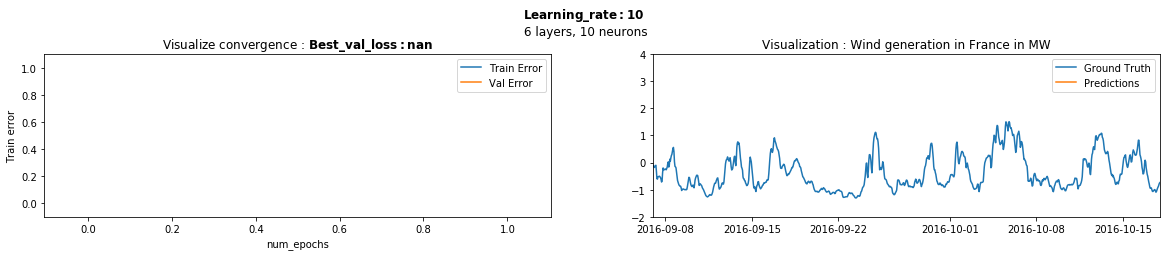

---------------------------------------------------------------------------------------------------------------------


In [27]:
num_epochs = 2
batch_size=32
criterion = nn.MSELoss()
test_learning_rate = [0.001,0.01,0.1,1,10]

hidden_layers = [3, 3, 6, 6]
neurons = [5, 10, 5, 10]
#nb_models = len(neurons)

for model_idx in range(len(neurons)):
    #plt.figure(figsize=(18,3))
    #plt.suptitle('$\mathit{Comparing\ models\ with\ a\ learning\ rate\ of\ %s }$' % (str(lr)),
    #             y=1.15)
    for lr in test_learning_rate:
        model = MultiLayerModel(n_hidden_layers=hidden_layers[model_idx], n_neurons=neurons[model_idx],
                                hidden_activations=torch.relu)
        #print('The model used is :\n', model)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
        train_error, validation_error = train(num_epochs, batch_size, criterion, optimizer, model,
                                              train_set, display=False)
        
        plot_convergence(train_error, validation_error, model, 
                         title="$\mathbf{Learning\_rate : %s }$ \n %d layers, %d neurons" % (str(lr),
                                                                                    hidden_layers[model_idx],
                                                                                    neurons[model_idx]))
        plt.show()
        #plt.subplot(1, nb_models, model_idx+1)
        #plt.plot(range(1, num_epochs+1), train_error, label='Train Error')
        #plt.plot(range(1, num_epochs+1), validation_error, label='Val Error')
        #plt.xlabel("num_epochs")
        #plt.ylabel("Train error")
        #plt.legend()
        #plt.title("%d layers, %d neurons\n $\mathbf{Best\_val\_loss : %.4f \%%}$" % (hidden_layers[model_idx], 
        #                                                                           neurons[model_idx],
        #                                                                           validation_error[-1]))
    
    print('-'*117)

---

**Impact of the number of epochs :**

We already know that the number of epochs will highly impact the results but it is very interesting to have a look at how it impacts the results (GIF ?).

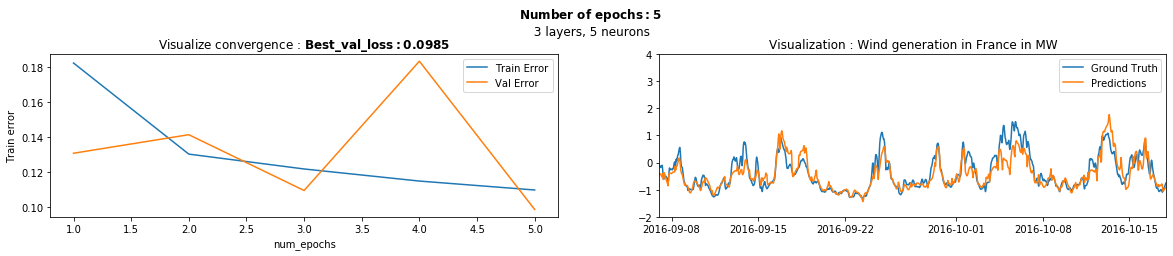

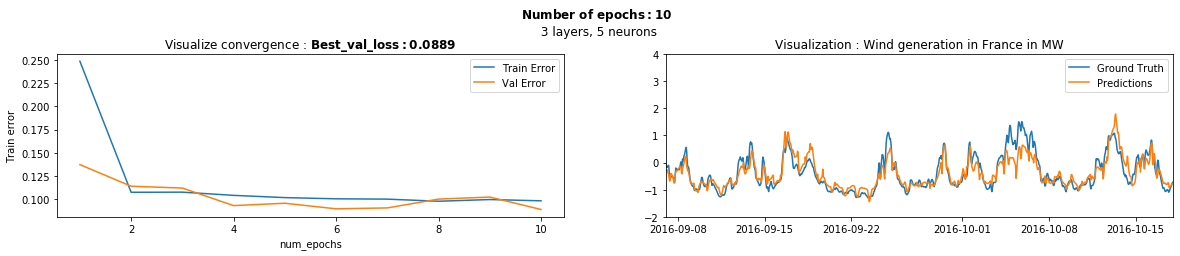

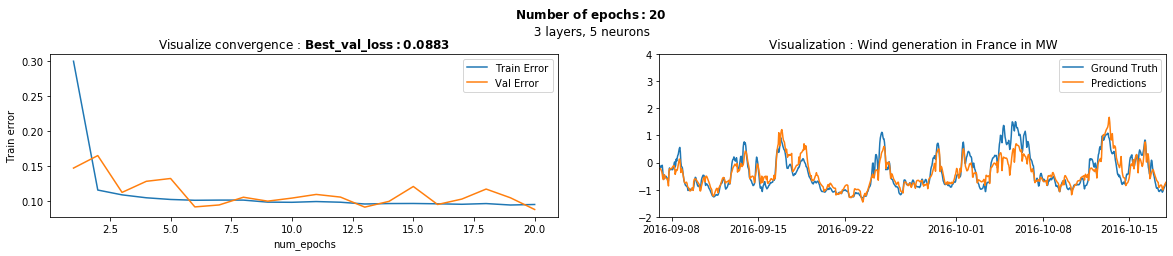

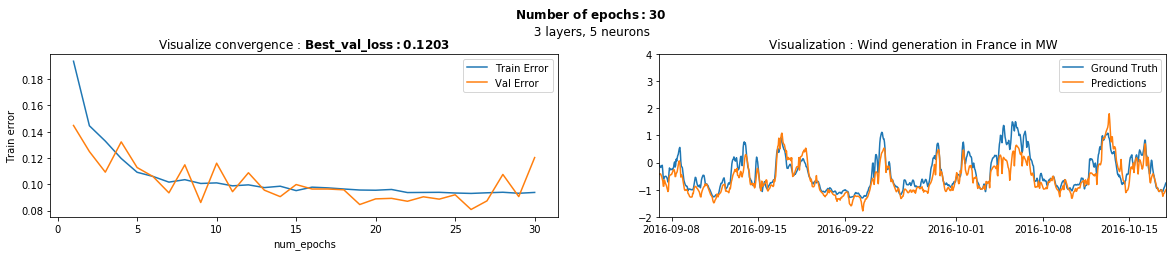

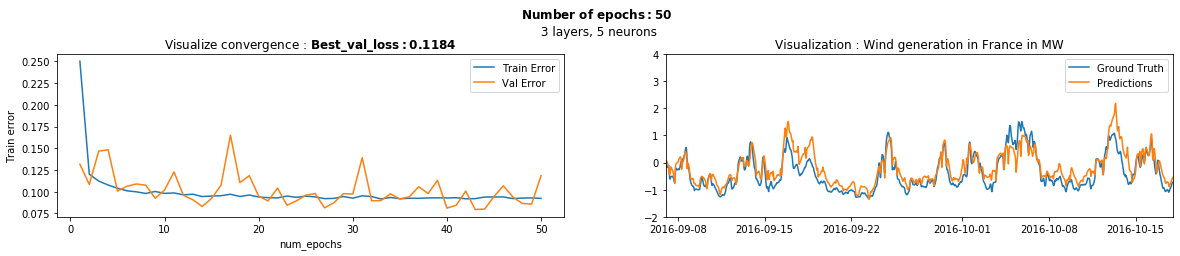

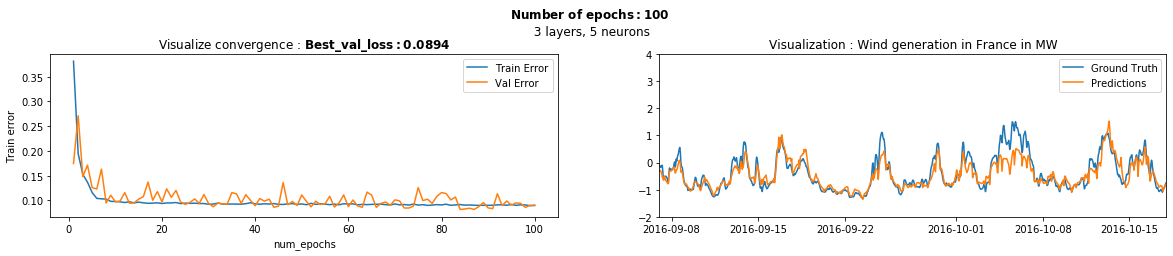

---------------------------------------------------------------------------------------------------------------------


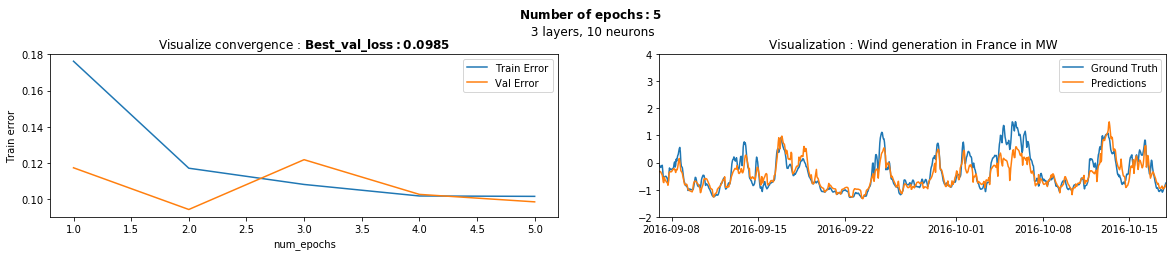

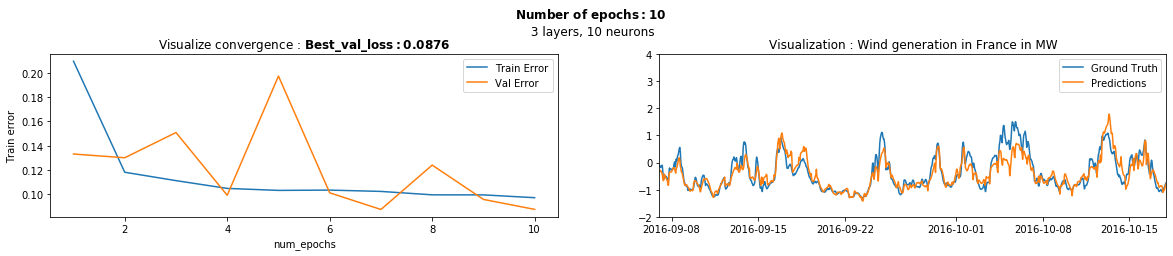

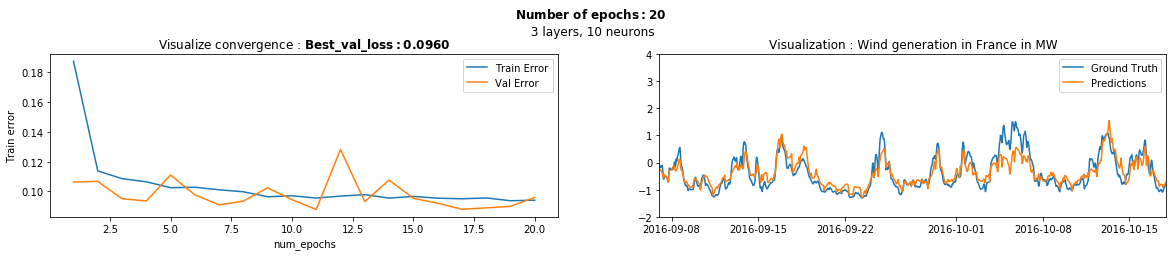

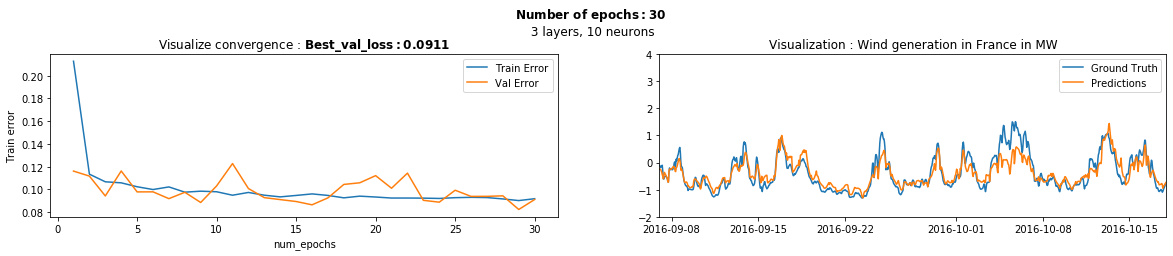

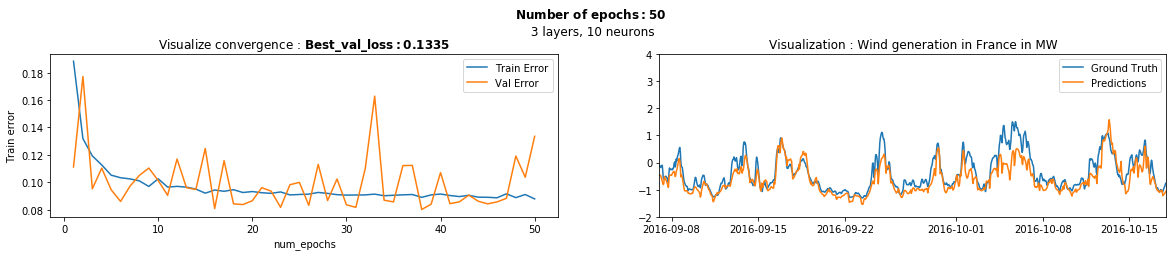

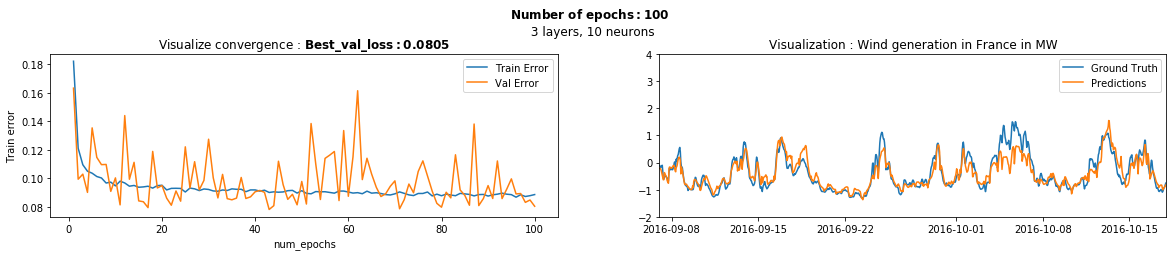

---------------------------------------------------------------------------------------------------------------------


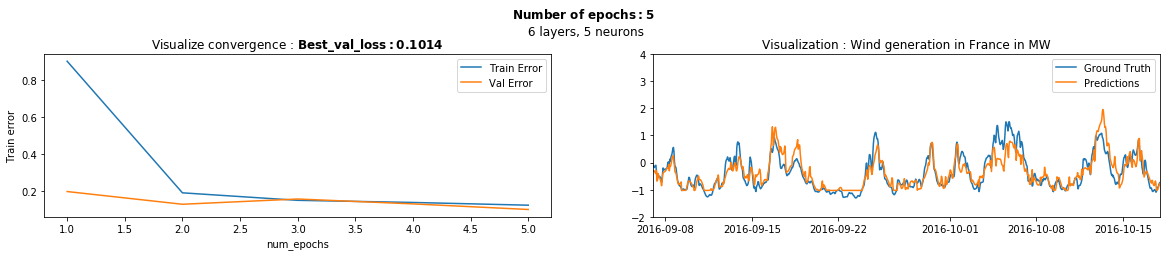

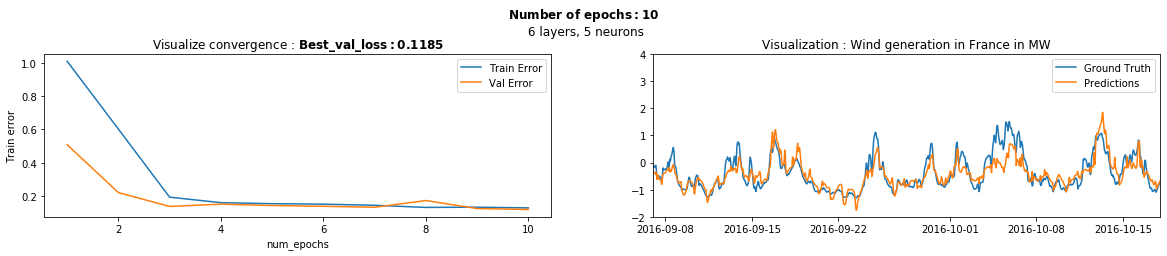

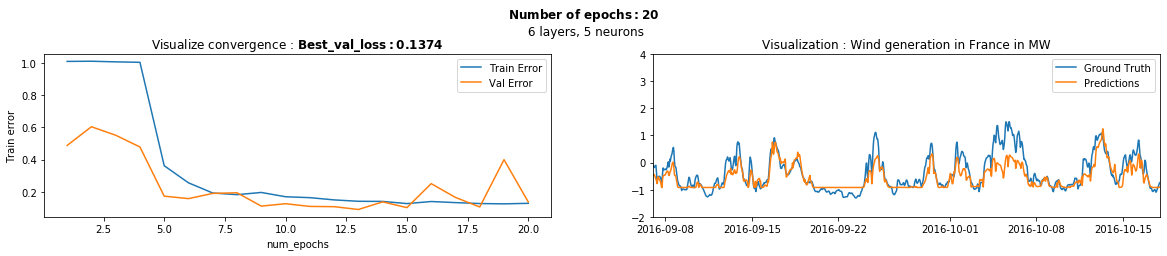

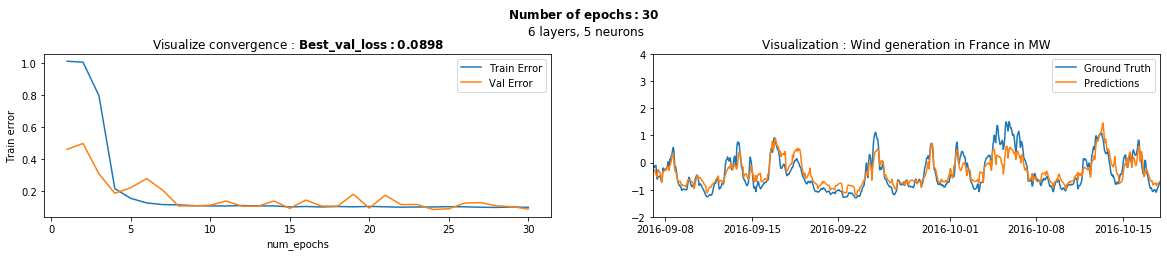

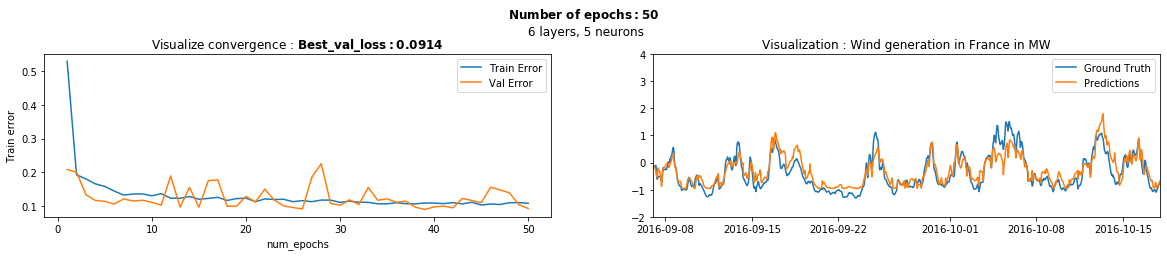

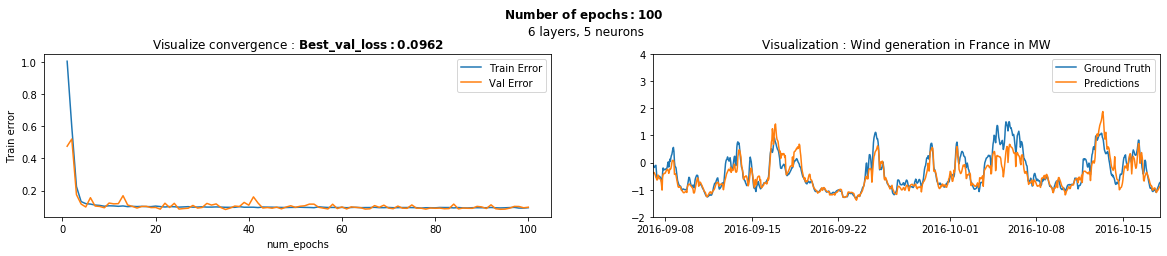

---------------------------------------------------------------------------------------------------------------------


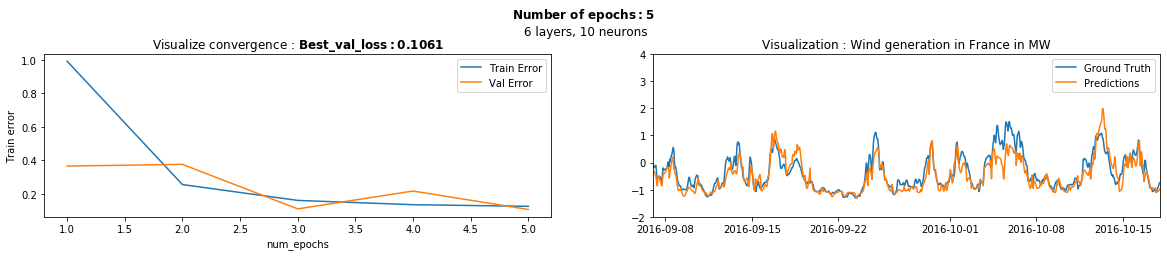

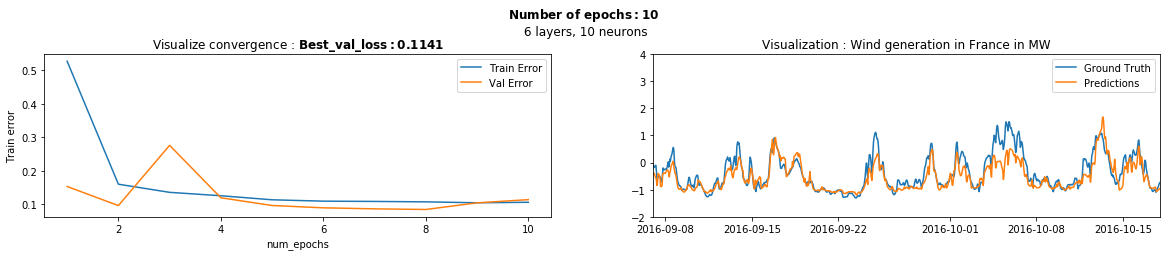

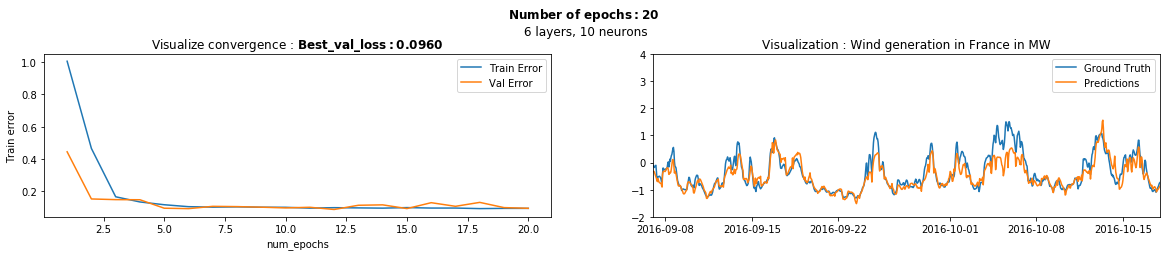

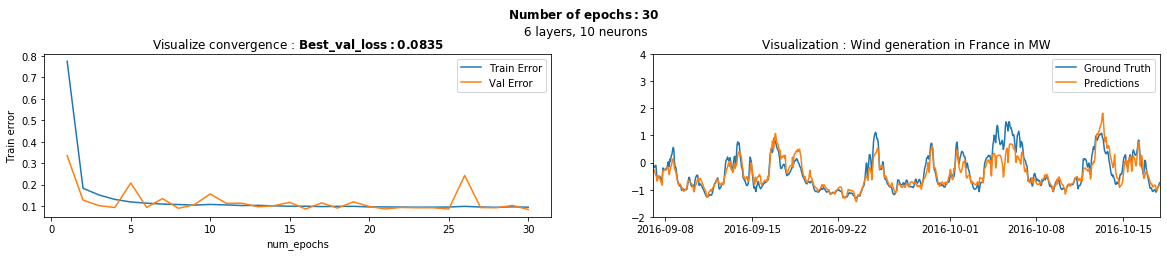

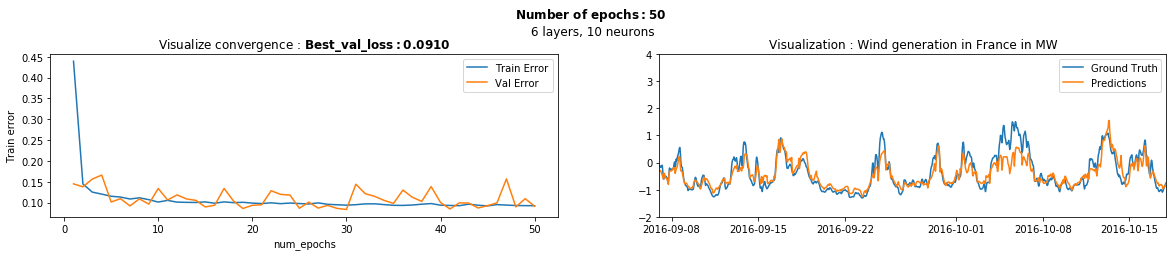

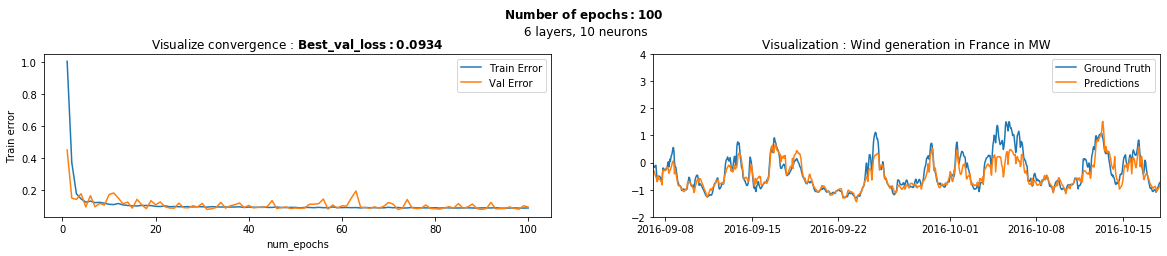

---------------------------------------------------------------------------------------------------------------------


In [28]:
batch_size=32
test_epochs = [5,10,20,30,50,100]
hidden_layers = [3, 3, 6, 6]
neurons = [5, 10, 5, 10]
#nb_models = len(neurons)

for model_idx in range(len(neurons)):
    #plt.figure(figsize=(18,3))
    #plt.suptitle('$\mathit{Comparing\ models\ with\ a\ number\ of\ epochs\ of\ %s }$' % (str(epochs)),
    #             y=1.15)
    for epochs in test_epochs:
        model = MultiLayerModel(n_hidden_layers=hidden_layers[model_idx], n_neurons=neurons[model_idx],
                                hidden_activations=torch.relu)
        #print('The model used is :\n', model)
        optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
        train_error, validation_error = train(epochs, batch_size, criterion, optimizer, model,
                                              train_set, display=False)
        
        plot_convergence(train_error, validation_error, model, 
                         title="$\mathbf{Number\ of\ epochs : %s }$ \n %d layers, %d neurons" % (str(epochs),
                                                                                    hidden_layers[model_idx],
                                                                                    neurons[model_idx]))
        plt.show()
        #plt.subplot(1, nb_models, model_idx+1)
        #plt.plot(range(1, epochs+1), train_error, label='Train Error')
        #plt.plot(range(1, epochs+1), validation_error, label='Val Error')
        #plt.xlabel("num_epochs")
        #plt.ylabel("Train error")
        #plt.legend()
        #plt.title("%d layers, %d neurons\n $\mathbf{Best\_val\_loss : %.4f \%%}$" % (hidden_layers[model_idx], 
        #                                                                             neurons[model_idx],
        #                                                                             validation_error[-1]))
    print('-'*117)

> Interesting to notice that from 5 to 10 epochs the model is getting worse even though it trains more. However, it then gets much better. It seems that at first, the model needs to get off a local minimum and thus have its performances get worse for a while, before getting better in a better local minimum.

---

**Impact of the optimizer :**

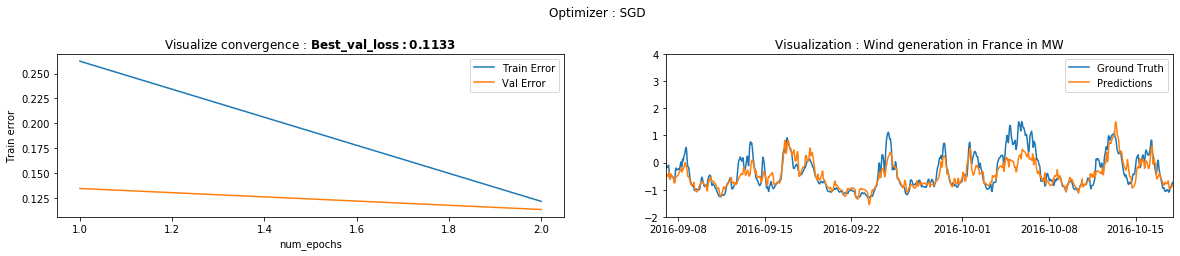

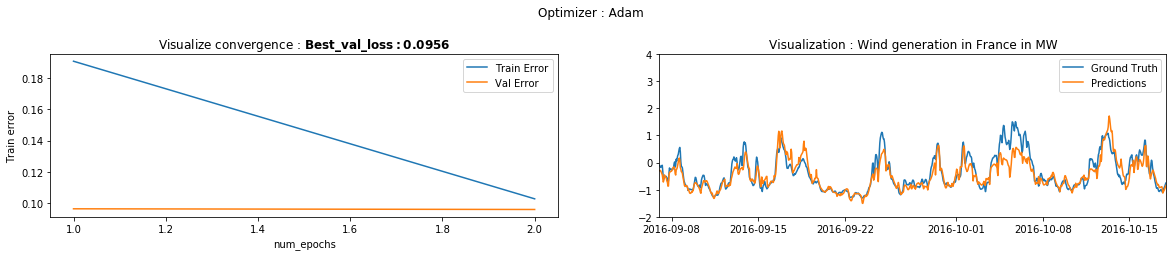

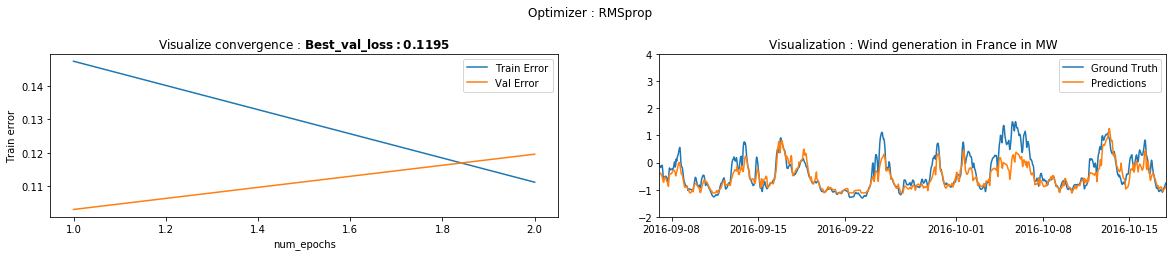

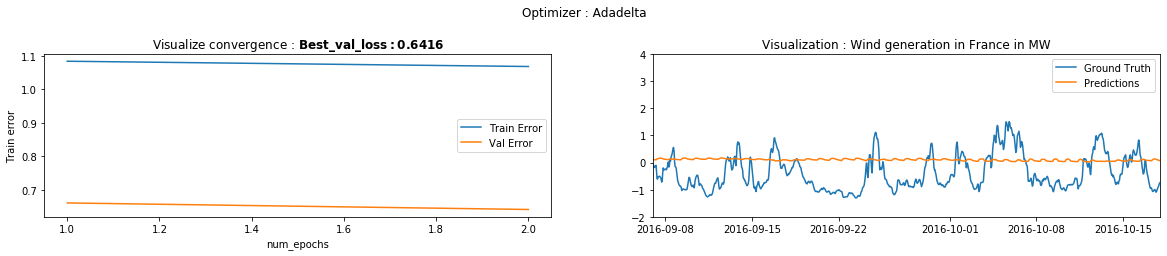

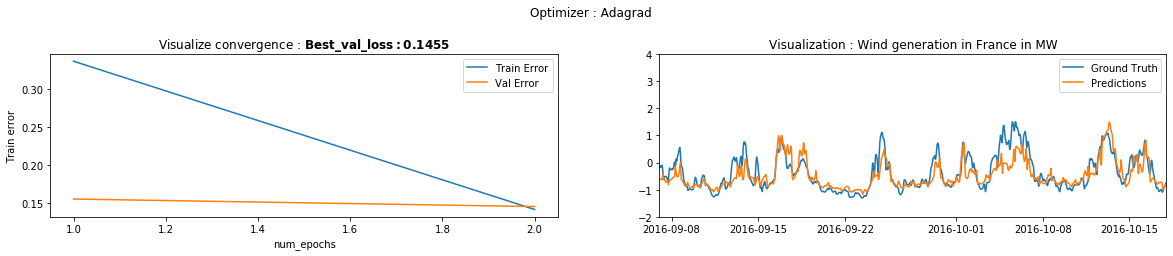

In [29]:
num_epochs = 2
batch_size=32
test_optimizers = [torch.optim.SGD, torch.optim.Adam, torch.optim.RMSprop, 
                   torch.optim.Adadelta, torch.optim.Adagrad]
#nb_models = len(test_optimizers)

#plt.figure(figsize=(16,3))
#plt.suptitle('$\mathit{Comparing\ the\ optimizer,\ using\ 3\ hidden\ layers,\ 7\ neurons\ and\ relu\ activation}$',
#             y=1.15)
for model_idx, optim in enumerate(test_optimizers):
    ### Train the model
    model = MultiLayerModel(n_hidden_layers=3, n_neurons=7, hidden_activations=torch.relu)
    #print('The model used is :\n', model)
    optimizer = optim(model.parameters(), lr=0.01)
    if optim.__name__=='SGD':
        state = optimizer.__getstate__()
        state['param_groups'][0]['lr'] = 0.1
        optimizer.__setstate__(state)
    train_error, validation_error = train(num_epochs, batch_size, criterion, optimizer, model,
                                          train_set, display=False)

    #plt.subplot(1, nb_models, model_idx+1)
    plot_convergence(train_error, validation_error, model, title='Optimizer : {}'.format(optim.__name__))

### Exercise 3: Impact of the loss function
As mensioned before in the first problem (binary classification), one can minimize the negative of log-likelihood of the probability for all samples $x$: $$ \sum_{(x,y) \,\in\, \text{Dataset}} - \log p(y | x) $$ If we define $p(y_i | x_i) = \frac{1}{\sqrt{2\pi}}e^{-\frac{(y_i - f(x_i))^2}{2}}$, then the loss function becomes the mean squared error. 

There is another loss function worth to try: the Gaussian likelihood loss function. 
Rather than predicting a single value $y$ given $x$, we predict a probability distribution over possible answers, which helps dealing with ambiguous cases and expressing uncertainty. To do this, for each possible input $x$, the network will output the parameters of the distribution modeling $p(y|x)$. For instance in our case, we choose to model output distributions with Gaussian distributions $\mathcal{N}(\mu, \sigma)$, which are parameterized by their mean $\mu$ and their standard deviation $\sigma$. Therefore for each input $x$ we have to output two quantities: $\mu(x)$ and $\sigma(x)$. The probability becomes: $$p(y_i | x_i) = \frac{1}{\sqrt{2\pi \sigma(x_i)^2}}e^{-\frac{(y_i - \mu(x_i))^2}{2\sigma(x_i)^2}}$$ Then the loss function becomes: $$L =\sum\limits_{i=1}^{N}  \frac{1}{2} \log ( 2\pi\sigma_i^{2} ) + \frac{1}{2\sigma_i^{2}}  (y_{i} - \mu_i)^{2}$$ If we set $\sigma=1$, we obtain MSE the loss function. 

* Try to replace the loss function with this one, and compare the differences between the two losses.
 
* **Hints**: 
    * You need two outputs of your network, one represents the $\mu(x_i)$, another for $\log( \sigma(x_i)^2 )$ (better for optimization) 
    * Try deeper models, or you will not predict the variance $\sigma$ well. 


In [44]:
def custom_loss(output,target):
    """
    input :
    -------
        output: torch tensor
            the output of the model of size (batch_size,2)
        target: torch tensor
            the target of size (batch_size,)
            
    return :
    -------
        A tensor which is the loss presented in the text above
    """
    first_part = output[:,1]
    second_part = (target-output[:,0])**2 / (torch.exp(output[:,1]))
    
    return torch.sum(first_part+second_part), torch.sum(first_part), torch.sum(second_part)

In [39]:
n_hidden_layers=150
n_neurons=30

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 32

# Training criterion. Use the custom loss defined above :
criterion = custom_loss

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
model = MultiLayerModel(n_hidden_layers, n_neurons, hidden_activations=torch.tanh, nb_output=2)
print('The model used is :\n', model)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

#train_error, validation_error = train(num_epochs, batch_size, criterion, optimizer, model, 
#                                      train_set, display=True)
dataloader = DataLoader(train_set, batch_size, shuffle=True)
for epoch in range(num_epochs):
    ### Train the model
    model.train()
    epoch_average_loss = 0.0
    epoch_average_loss_first = 0.0
    epoch_average_loss_second = 0.0
    for (X, y) in (dataloader):

        y_pre = model(X)
        if y_pre.shape[1]==1:
            y_pre = y_pre.view(-1)
        loss_train, first_loss_train, second_loss_train = criterion(y_pre, y)
        #print('Total loss : {:.4f} \t| Std_loss : {:.4f} \t| Mean_loss : {:.4f}'.format(loss_train, 
        #                                                                                first_loss_train, 
        #                                                                                second_loss_train))
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        epoch_average_loss += loss_train.item() * batch_size / len(train_set)
        epoch_average_loss_first += first_loss_train.item() * batch_size / len(train_set)
        epoch_average_loss_second += second_loss_train.item() * batch_size / len(train_set)

    ### Evaluate the performance of our model
    model.eval()
    with torch.no_grad():
        y_pre_val = model(torch.from_numpy(np.array(X_val)).float())
        loss_val, first_loss_val, second_loss_val = criterion(y_pre_val, torch.tensor(np.array(y_val)).float())
        loss_val = loss_val.item() * batch_size / len(y_val)
        first_loss_val = first_loss_val * batch_size / len(y_val)
        second_loss_val = second_loss_val * batch_size / len(y_val)

    to_plot = '-'*117+'\n'
    to_plot+='Epoch [{}/{}] :\n'.format(epoch+1, num_epochs)
    to_plot+='Train_Loss_error: {:.4f}, Train_Std_Loss: {:.4f}, Train_Mean_Loss: {:.4f}\n'.format(
                                                                                    epoch_average_loss,
                                                                                    epoch_average_loss_first,
                                                                                    epoch_average_loss_second)
    to_plot+='Valid_Loss_error: {:.4f}, Valid_Std_Loss: {:.4f}, Valid_Mean_Loss: {:.4f}'.format(
                                                                                    loss_val,
                                                                                    first_loss_val,
                                                                                    second_loss_val)
    print(to_plot)

The model used is :
 MultiLayerModel(
  (layer_1): Linear(in_features=3, out_features=30, bias=True)
  (layer_2): Linear(in_features=30, out_features=30, bias=True)
  (layer_3): Linear(in_features=30, out_features=30, bias=True)
  (layer_4): Linear(in_features=30, out_features=30, bias=True)
  (layer_5): Linear(in_features=30, out_features=30, bias=True)
  (layer_6): Linear(in_features=30, out_features=30, bias=True)
  (layer_7): Linear(in_features=30, out_features=30, bias=True)
  (layer_8): Linear(in_features=30, out_features=30, bias=True)
  (layer_9): Linear(in_features=30, out_features=30, bias=True)
  (layer_10): Linear(in_features=30, out_features=30, bias=True)
  (layer_11): Linear(in_features=30, out_features=30, bias=True)
  (layer_12): Linear(in_features=30, out_features=30, bias=True)
  (layer_13): Linear(in_features=30, out_features=30, bias=True)
  (layer_14): Linear(in_features=30, out_features=30, bias=True)
  (layer_15): Linear(in_features=30, out_features=30, bias=Tru

> Very interesting to notice that when using this approach in fact it is much simpler to minimize the $log(\sigma^{2})$ since it is un bounded and the derivative is much more important when $\sigma$ is approaching 0, than the square of $\mu$. Thus, in fact the part of the loss corresponding to the standard deviation of the model is very negative and decreasing, while the part of the loss corresponding to the mean value is positive and increasing. This last remark is interesting since the model is not able to minimize both ! Indeed, this is related to the fact that the integral over $\mathbb{R}$ of the probability density is 1 and thus the two values are inherently related.

In [45]:
n_hidden_layers=50
n_neurons=30

# Choose the hyperparameters for training: 
num_epochs = 50
batch_size = 32

# Training criterion. Use the custom loss defined above :
criterion = custom_loss

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
model = MultiLayerModel(n_hidden_layers, n_neurons, hidden_activations=torch.tanh, nb_output=2)
print('The model used is :\n', model)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5)

#train_error, validation_error = train(num_epochs, batch_size, criterion, optimizer, model, 
#                                      train_set, display=True)
dataloader = DataLoader(train_set, batch_size, shuffle=True)
for epoch in range(num_epochs):
    ### Train the model
    model.train()
    epoch_average_loss = 0.0
    epoch_average_loss_first = 0.0
    epoch_average_loss_second = 0.0
    for (X, y) in (dataloader):

        y_pre = model(X)
        if y_pre.shape[1]==1:
            y_pre = y_pre.view(-1)
        loss_train, first_loss_train, second_loss_train = criterion(y_pre, y)
        #print('Total loss : {:.4f} \t| Std_loss : {:.4f} \t| Mean_loss : {:.4f}'.format(loss_train, 
        #                                                                                first_loss_train, 
        #                                                                                second_loss_train))
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        epoch_average_loss += loss_train.item() * batch_size / len(train_set)
        epoch_average_loss_first += first_loss_train.item() * batch_size / len(train_set)
        epoch_average_loss_second += second_loss_train.item() * batch_size / len(train_set)

    ### Evaluate the performance of our model
    model.eval()
    with torch.no_grad():
        y_pre_val = model(torch.from_numpy(np.array(X_val)).float())
        loss_val, first_loss_val, second_loss_val = criterion(y_pre_val, torch.tensor(np.array(y_val)).float())
        loss_val = loss_val.item() * batch_size / len(y_val)
        first_loss_val = first_loss_val * batch_size / len(y_val)
        second_loss_val = second_loss_val * batch_size / len(y_val)

    to_plot = '-'*117+'\n'
    to_plot+='Epoch [{}/{}] :\n'.format(epoch+1, num_epochs)
    to_plot+='Train_Loss_error: {:.4f}, Train_Std_Loss: {:.4f}, Train_Mean_Loss: {:.4f}\n'.format(
                                                                                    epoch_average_loss,
                                                                                    epoch_average_loss_first,
                                                                                    epoch_average_loss_second)
    to_plot+='Valid_Loss_error: {:.4f}, Valid_Std_Loss: {:.4f}, Valid_Mean_Loss: {:.4f}'.format(
                                                                                    loss_val,
                                                                                    first_loss_val,
                                                                                    second_loss_val)
    print(to_plot)

The model used is :
 MultiLayerModel(
  (layer_1): Linear(in_features=3, out_features=30, bias=True)
  (layer_2): Linear(in_features=30, out_features=30, bias=True)
  (layer_3): Linear(in_features=30, out_features=30, bias=True)
  (layer_4): Linear(in_features=30, out_features=30, bias=True)
  (layer_5): Linear(in_features=30, out_features=30, bias=True)
  (layer_6): Linear(in_features=30, out_features=30, bias=True)
  (layer_7): Linear(in_features=30, out_features=30, bias=True)
  (layer_8): Linear(in_features=30, out_features=30, bias=True)
  (layer_9): Linear(in_features=30, out_features=30, bias=True)
  (layer_10): Linear(in_features=30, out_features=30, bias=True)
  (layer_11): Linear(in_features=30, out_features=30, bias=True)
  (layer_12): Linear(in_features=30, out_features=30, bias=True)
  (layer_13): Linear(in_features=30, out_features=30, bias=True)
  (layer_14): Linear(in_features=30, out_features=30, bias=True)
  (layer_15): Linear(in_features=30, out_features=30, bias=Tru

torch.Size([32]) tensor([-0.8598, -0.8608,  1.8036,  0.3291, -1.1195,  1.0480,  0.3167, -0.4658,
         1.1650, -0.7628,  0.7381, -0.8996,  0.1135, -1.0247,  0.3905,  0.7872,
        -0.7881,  0.2235, -0.6938, -1.1745, -0.2831, -0.9778,  0.4660, -1.0667,
         1.9308, -0.3812, -0.7509, -0.4135, -0.3984, -1.1432, -1.0570, -0.1489],
       grad_fn=<SubBackward0>)
torch.Size([32]) tensor([-0.4068,  2.2355, -1.2158, -0.4769, -0.0118, -0.9571, -0.2657, -0.6510,
         1.1840, -0.8649, -0.7733, -1.1037,  0.2743, -0.7194, -0.8434, -0.9609,
        -0.9151, -1.3413,  0.4673, -1.2928, -0.6612, -0.8094, -1.1559, -0.6553,
        -1.1500,  0.1396, -1.3155,  0.0577, -0.9910, -0.8730, -0.1115, -0.6752],
       grad_fn=<SubBackward0>)
torch.Size([32]) tensor([-1.0395,  0.0421, -0.1066, -0.3836,  0.6457, -1.1710,  0.7454, -0.4591,
         0.1467, -0.8449, -0.3545,  0.2997, -0.5437, -1.1112, -1.1246,  2.2458,
        -0.4774, -0.5377, -0.5512, -0.8255, -0.0964,  2.4694, -0.8746, -0.7048,
     

torch.Size([32]) tensor([ 2.8229, -0.7021,  0.6629,  2.7410, -0.5216, -0.2274,  0.6743, -0.5933,
        -0.7345, -0.8848, -0.6391,  0.8332, -0.0538,  1.8518,  3.1452, -0.7566,
        -0.5938, -1.0347, -1.2416, -0.1282, -0.6790, -0.9678, -0.7884,  1.8766,
        -0.7070,  1.4880,  2.3562,  0.0895, -0.3465,  0.1456,  2.6171, -0.4553],
       grad_fn=<SubBackward0>)
torch.Size([32]) tensor([-1.0905, -1.1325, -0.1544,  0.7461, -0.3910,  1.6068, -1.1584,  0.1253,
         0.2686, -0.0402, -0.7623,  1.7922,  0.0272, -0.7267,  0.1151, -0.4573,
         0.7758, -1.2904, -0.4266, -0.9089, -1.1266, -1.1660,  1.3341,  2.1489,
         1.5475, -0.3991,  0.4309, -0.3549, -0.8351,  1.0404, -0.4163,  0.5316],
       grad_fn=<SubBackward0>)
torch.Size([32]) tensor([ 0.0380,  0.4363, -0.0202,  0.5403,  1.0598,  2.1446,  1.2112,  0.7084,
        -1.1999, -0.7515, -0.7041,  0.6863,  1.1821, -0.9811,  1.0501,  2.0352,
        -0.5995, -0.9730,  0.6308, -0.2061, -0.7634, -0.2746,  0.5430,  0.5570,
     

torch.Size([32]) tensor([ 0.9778,  0.9951,  0.3063, -0.3555,  2.3801,  1.1524,  0.2276,  0.2082,
        -0.4007,  1.8325,  1.0856, -0.7025,  2.6124, -0.1475, -1.1251,  0.4454,
         1.7937, -0.0828, -0.4978,  1.4036, -0.3091,  2.3876,  0.6561,  0.8285,
         0.1980,  3.1012,  0.3958, -0.2703, -0.6438, -0.7209, -0.2930, -1.1412],
       grad_fn=<SubBackward0>)
torch.Size([32]) tensor([ 1.7150,  0.0169, -0.4655, -0.5296, -0.7538, -0.6067, -1.2216, -0.8734,
         1.4342,  0.3327,  0.1106,  1.1060, -1.1310, -1.3024, -0.8928,  0.4329,
        -1.2076,  1.8158, -0.8082, -1.0577, -1.0351, -0.6956, -0.1674,  3.0655,
        -0.6686, -0.4261, -0.1987,  0.6986, -1.0599, -0.9036, -0.5339, -0.8244],
       grad_fn=<SubBackward0>)
torch.Size([32]) tensor([-0.6749, -1.0047, -0.1079, -0.1090, -0.7827,  0.4164,  0.8341,  1.6932,
         1.1122,  3.0318, -0.7212, -1.2515, -1.1378, -0.4437, -0.0772, -1.0074,
        -0.6544,  1.0497,  1.4118,  1.3515, -0.1548,  0.7091,  1.5573,  1.3849,
     

torch.Size([32]) tensor([ 0.9563, -0.0035, -1.1024, -0.6939, -0.9073,  0.5295, -0.6615, -0.6103,
        -0.3808, -0.3554, -0.0968,  1.1773, -0.9418, -0.3770, -1.2662, -1.0393,
        -0.8448,  1.2743,  1.8854, -0.4966, -0.4471, -0.4762, -0.7241, -0.0784,
         1.4219,  0.3845, -0.6152,  0.6276, -0.4406, -0.7327, -0.5829, -0.5699],
       grad_fn=<SubBackward0>)
torch.Size([32]) tensor([ 0.8768, -0.2851, -1.0989,  1.0729, -1.1959, -0.2604, -1.2304,  0.6914,
        -0.3347, -0.3892, -1.3037, -0.5783, -0.1375, -1.0353, -1.0030, -0.1801,
         1.7390, -0.6484, -0.8014, -0.8198, -1.1851,  1.4286, -0.1062, -0.3336,
        -1.1550, -0.7556,  0.6784, -1.1000, -1.1722,  2.2187, -0.9243, -1.2153],
       grad_fn=<SubBackward0>)
torch.Size([32]) tensor([-0.5483,  0.3242, -0.3392, -0.7590, -0.9482,  2.4530, -1.0328, -0.2815,
        -0.9347,  0.1453, -0.1349, -0.8528, -0.4637, -0.8851, -1.0172, -0.4852,
        -0.9315,  0.5538, -0.0708,  0.2035, -0.8447, -0.2287,  1.4096, -0.4648,
     

KeyboardInterrupt: 

Text(0.5, 1.0, 'Train error, using MSE')

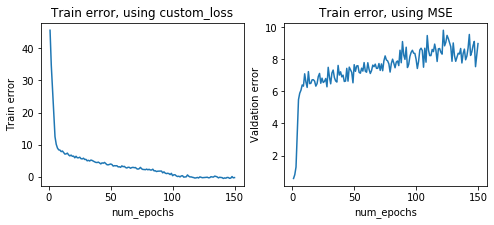

In [364]:
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title('Train error, using custom_loss')
plt.subplot(122)
plt.plot(range(1, num_epochs+1), validation_error)
plt.xlabel("num_epochs")
plt.ylabel("Valdation error")
plt.title('Train error, using MSE')

In [47]:
y_pre_val = model(torch.from_numpy(np.array(X_train.head(100))).float())
sigma = y_pre_val[:,0]
y_pre_val = y_pre_val[:,1]
for idx in range(len(sigma)):
    print(y_pre_val[idx], y_train.head(100).values[idx], sigma[idx])

tensor([0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819,
        0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819,
        0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819,
        0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819,
        0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819,
        0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819,
        0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819,
        0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819,
        0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819,
        0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819,
        0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819,
        0.0819], grad_fn=<SelectBackward>)
tensor([0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.0819, 0.081

### Exercice 4: Prediction on test set

* Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.
* When using the Gaussian likelihood function, the confidence of the network in its prediction is reflected in the variance it outputs. It can be interesting to check how this uncertainty varies with the data. For example, the uncertainty will decrease when the feature `FR_radiation_direct_horizontal` increases. Plot the variance $\sigma(x)$ w.r.t one of the three features, on test set, and describe what you observe.